## Load Modules

In [1]:
using MLJ
using MultivariateStats
using Plots; gr()
using StatsPlots
using DataFrames
using PyCall

using CSV: read
using StatsBase: countmap, kurtosis
using Clustering: randindex, silhouettes, varinfo, vmeasure, mutualinfo
using LinearAlgebra: diag

In [2]:
ENV["LINES"] = 100;

In [3]:
RNG = 133;

## Import Data and Set Up

In [4]:
data = read("balance.csv")
data[!,2:end] = float.(data[:,2:end])

,Left_Weight,Left_Distance,Right_Weight,Right_Distance
,Float64,Float64,Float64,Float64
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,2.0
3,1.0,1.0,1.0,3.0
4,1.0,1.0,1.0,4.0
5,1.0,1.0,1.0,5.0
6,1.0,1.0,2.0,1.0
7,1.0,1.0,2.0,2.0
8,1.0,1.0,2.0,3.0
9,1.0,1.0,2.0,4.0


In [5]:
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,Class_Name,,B,,R,3,,String
2,Left_Weight,3.0,1.0,3.0,5.0,,,Float64
3,Left_Distance,3.0,1.0,3.0,5.0,,,Float64
4,Right_Weight,3.0,1.0,3.0,5.0,,,Float64
5,Right_Distance,3.0,1.0,3.0,5.0,,,Float64


In [6]:
label_counts = countmap(data[:(Class_Name)])
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

3-element Array{Float64,1}:
 0.0784
 0.4608
 0.4608

In [7]:
coerce!(data, :Class_Name=>Multiclass)
schema(data)

┌────────────────┬─────────────────────────────────┬───────────────┐
│ _.names        │ _.types                         │ _.scitypes    │
├────────────────┼─────────────────────────────────┼───────────────┤
│ Class_Name     │ CategoricalValue{String,UInt32} │ Multiclass{3} │
│ Left_Weight    │ Float64                         │ Continuous    │
│ Left_Distance  │ Float64                         │ Continuous    │
│ Right_Weight   │ Float64                         │ Continuous    │
│ Right_Distance │ Float64                         │ Continuous    │
└────────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 625


In [8]:
y, X = unpack(data, ==(:Class_Name), colname->true)
train, test = partition(eachindex(y), 0.8, shuffle=true, rng=RNG, stratify=values(data[:Class_Name])) # gives 70:30 split

([342, 589, 478, 524, 282, 88, 9, 114, 564, 491  …  278, 274, 284, 467, 56, 407, 17, 109, 428, 401], [413, 566, 519, 240, 587, 61, 20, 312, 490, 334  …  356, 338, 361, 19, 567, 423, 176, 561, 371, 259])

#### Confirming that data was stratified correctly

In [9]:
train_counts = countmap(data[train,:Class_Name])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

3-element Array{Float64,1}:
 0.0781563126252505
 0.46092184368737477
 0.46092184368737477

In [10]:
test_counts = countmap(data[test,:Class_Name])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

3-element Array{Float64,1}:
 0.07936507936507936
 0.4603174603174603
 0.4603174603174603

#### Not standardizing

In [11]:
train_data = convert(Matrix,X[train,:])

499×4 Array{Float64,2}:
 3.0  4.0  4.0  2.0
 5.0  4.0  3.0  4.0
 4.0  5.0  1.0  3.0
 5.0  1.0  5.0  4.0
 3.0  2.0  2.0  2.0
 1.0  4.0  3.0  3.0
 1.0  1.0  2.0  4.0
 1.0  5.0  3.0  4.0
 5.0  3.0  3.0  4.0
 4.0  5.0  4.0  1.0
 3.0  1.0  5.0  5.0
 3.0  2.0  3.0  3.0
 5.0  3.0  1.0  4.0
 3.0  3.0  3.0  1.0
 5.0  2.0  2.0  1.0
 2.0  4.0  1.0  4.0
 5.0  1.0  2.0  5.0
 3.0  3.0  2.0  1.0
 3.0  4.0  2.0  1.0
 3.0  1.0  1.0  5.0
 3.0  2.0  4.0  2.0
 3.0  2.0  4.0  1.0
 4.0  2.0  4.0  1.0
 2.0  2.0  4.0  5.0
 5.0  4.0  1.0  2.0
 2.0  1.0  3.0  4.0
 3.0  4.0  4.0  1.0
 5.0  5.0  2.0  5.0
 2.0  2.0  4.0  4.0
 1.0  2.0  2.0  2.0
 5.0  1.0  2.0  3.0
 2.0  1.0  1.0  2.0
 3.0  5.0  5.0  2.0
 2.0  3.0  3.0  5.0
 5.0  5.0  4.0  2.0
 4.0  3.0  5.0  5.0
 2.0  5.0  4.0  1.0
 5.0  4.0  2.0  5.0
 1.0  2.0  4.0  5.0
 5.0  2.0  5.0  3.0
 5.0  2.0  2.0  5.0
 2.0  5.0  3.0  2.0
 4.0  2.0  5.0  2.0
 4.0  5.0  4.0  2.0
 1.0  4.0  5.0  3.0
 5.0  5.0  1.0  1.0
 3.0  2.0  2.0  5.0
 5.0  4.0  3.0  3.0
 ⋮              

## Set up model

In [12]:
task(model) = !model.is_supervised
models(task)

32-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AffinityPropagation, package_name = ScikitLearn, ... )
 (name = AgglomerativeClustering, package_name = ScikitLearn, ... )
 (name = Birch, package_name = ScikitLearn, ... )
 (name = ContinuousEncoder, package_name = MLJModels, ... )
 (name = DBSCAN, package_name = ScikitLearn, ... )
 (name = FactorAnalysis, package_name = MultivariateStats, ... )
 (name = FeatureAgglomeration, package_name = ScikitLearn, ... )
 (name = FeatureSelector, package_name = MLJModels, ... )
 (name = FillImputer, package_name = MLJModels, ... )
 (name = ICA, package_name = MultivariateStats, ... )
 (name = KMeans, package_name 

# Clustering Algorithms
Run the clustering algorithms on the datasets and describe what you see.

### KMeans
* https://github.com/PyDataBlog/ParallelKMeans.jl/blob/master/src/hamerly.jl#L65
* https://juliastats.org/Clustering.jl/stable/validate.html

In [101]:
@load KMeans pkg=ParallelKMeans
# @load KMeans pkg=Clustering

KMeans(
    algo = ParallelKMeans.Hamerly(),
    k_init = "k-means++",
    k = 3,
    tol = 1.0e-6,
    max_iters = 300,
    copy = true,
    threads = 4,
    rng = Random._GLOBAL_RNG(),
    weights = nothing,
    init = nothing) @403

In [102]:
# https://stackoverflow.com/questions/51181392/julia-vs-matlab-distance-matrix-run-time-test
function dist_mat(X::Matrix)
    G = X * X'
    dG = diag(G)
    return sqrt.(dG .+ dG' .- 2 .* G)
end

dist_mat (generic function with 1 method)

In [230]:
upper = 10
k_range = 2:upper
total_costs = []
sils = []
ls = []
sil_means = []
km_assignments = []

for i in k_range
    println("K = $i")
    model = ParallelKMeans.KMeans(k=i, rng=RNG)
    mach = machine(model, X)
    MLJ.fit!(mach, rows=train)
    
#     @show report(mach) 
#     @show fitted_params(mach)
    @show mach.report.totalcost # https://github.com/PyDataBlog/ParallelKMeans.jl/blob/87ce07d10796078aacffcbea0b2e9dc0c02f25d7/src/hamerly.jl#L65
    d = countmap(mach.report.assignments)
    
    k = d |> keys
    v = d |> values
    l = sort(collect(zip(k,v)), by=x->x[1])
    @show l
    
    # https://juliastats.org/Clustering.jl/stable/validate.html
    s = silhouettes(mach.report.assignments, dist_mat(train_data))
    println("silhouette: $(mean(s))")
    
    push!(km_assignments, mach.report.assignments)
    push!(ls, l)
    push!(total_costs, mach.report.totalcost) 
    push!(sils, s)
    push!(sil_means, mean(s))
    println("")
end

K = 2
Iteration 1: Jclust = 4421.0
Iteration 2: Jclust = 3903.390410059722
Iteration 3: Jclust = 3933.408872707408
Iteration 4: Jclust = 3879.817794847365
Iteration 5: Jclust = 3824.6344015031214
Iteration 6: Jclust = 3822.316220650946
Iteration 7: Jclust = 3831.1352320367705
Iteration 8: Jclust = 3776.363611876285
Iteration 9: Jclust = 3783.784893877938
Iteration 10: Jclust = 3776.3021069779024
Iteration 11: Jclust = 3784.219707554757
Iteration 12: Jclust = 3789.6485774607067
Iteration 13: Jclust = 3740.4992408245976
Iteration 14: Jclust = 3753.958293780855
Iteration 15: Jclust = 3741.8581899346145
Iteration 16: Jclust = 3747.4966968166145
Iteration 17: Jclust = 3740.6438480627726
Iteration 18: Jclust = 3749.971605031644
Iteration 19: Jclust = 3715.1397171705926
Iteration 20: Jclust = 3673.8189799613765
Iteration 21: Jclust = 3683.1486548354146
Iteration 22: Jclust = 3648.486077488995
Iteration 23: Jclust = 3571.7907885821883
Iteration 24: Jclust = 3550.48717945605
Iteration 25: Jclus

┌ Info: Training Machine{KMeans} @442.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


[(1, 258), (2, 241)]
silhouette: 0.1830626307885436

K = 3
Iteration 1: Jclust = 4118.0
Iteration 2: Jclust = 3276.6970366465007
Iteration 3: Jclust = 3138.11855536009
Iteration 4: Jclust = 3046.255859913119
Iteration 5: Jclust = 3033.072418744619
Iteration 6: Jclust = 3059.1210173787476
Iteration 7: Jclust = 3077.6066111948103
Iteration 8: Jclust = 3099.3121993470704
Iteration 9: Jclust = 3085.431263487328
Iteration 10: Jclust = 3081.0316755332806
Iteration 11: Jclust = 3072.062718574553
Iteration 12: Jclust = 3078.5713844320726
Iteration 13: Jclust = 3092.2157772564387
Iteration 14: Jclust = 3067.2808011082975
Iteration 15: Jclust = 3079.2736765475083
Iteration 16: Jclust = 3077.816811603864
Iteration 17: Jclust = 3064.5100941165297
Iteration 18: Jclust = 3057.3251415544178
Iteration 19: Jclust = 3044.2123839846627
Iteration 20: Jclust = 3029.6732028025785
Iteration 21: Jclust = 3040.9776140946283
Iteration 22: Jclust = 3031.439931207913
Iteration 23: Jclust = 3039.197489748838
Itera

┌ Info: Training Machine{KMeans} @288.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Info: Training Machine{KMeans} @164.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Info: Training Machine{KMeans} @690.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Info: Training Machine{KMeans} @993.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Info: Training Machine{KMeans} @827.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Info: Training Machine{KMeans} @632.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Info: Training Machine{KMeans} @842.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


silhouette: 0.19561172083997486

K = 10
Iteration 1: Jclust = 2188.0
Iteration 2: Jclust = 1645.6366824972042
Iteration 3: Jclust = 1544.0607464576308
Iteration 4: Jclust = 1486.3943199798562
Iteration 5: Jclust = 1513.987166348829
Iteration 6: Jclust = 1531.2190198621918
Iteration 7: Jclust = 1539.5532358963428
Iteration 8: Jclust = 1515.5904818416827
Iteration 9: Jclust = 1489.5338870677335
Iteration 10: Jclust = 1496.303149417063
Iteration 11: Jclust = 1496.5893633848134
Iteration 12: Jclust = 1492.4669746548514
Iteration 13: Jclust = 1492.4669746548514
Successfully terminated with convergence.
mach.report.totalcost = 1396.999794108121
l = [(1, 57), (2, 54), (3, 52), (4, 47), (5, 53), (6, 49), (7, 40), (8, 40), (9, 59), (10, 48)]
silhouette: 0.19348249136126539



┌ Info: Training Machine{KMeans} @570.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


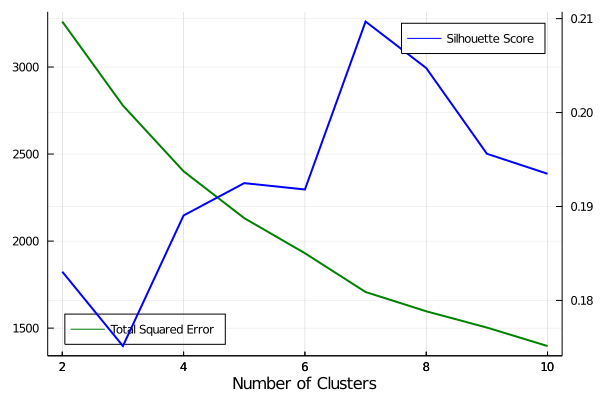

In [231]:
plot(k_range, total_costs, legend=:bottomleft, label="Total Squared Error", color=:green, lw=2)
xlabel!("Number of Clusters")
plot!(twinx(), k_range, sil_means, legend=:topright, label="Silhouette Score", color=:blue, lw=2)

In [232]:
savefig("figures/bal_kmeans_metrics_$upper")

In [233]:
function prepare_portfolio(ls)
    N = size(ls)[1]
    D = size(ls[end])[1]
    mat = zeros(N, D)
    for i in 1:N
#         print("\n")
#         @show i
        for j in 1:size(ls[i])[1]
#             @show j
            mat[i,j] = ls[i][j][2]
        end
    end
    return mat
end

prepare_portfolio (generic function with 1 method)

In [234]:
function cum_columns(mat; normalize=false)
    mat2 = deepcopy(mat)
    normalize && (mat2 ./= sum(mat2, dims = 2)) # if you want to normalize each row
    for i in 2:size(mat2)[2]
       mat2[:,i] = mat2[:,i-1] + mat2[:,i]
    end
    return mat2'
end

cum_columns (generic function with 1 method)

In [235]:
function cum_plot(mat)
    N = size(mat)[2]
    p = plot(legend=:outertopright, palette=palette(:Accent_8))
    for i in N+1:-1:1
        plot!(1:N, mat[i,:], label="Cluster $(i)", fill=0, α=1)
    end
    xticks!(collect(1:N),string.(collect(2:N+1)))
    ylabel!("Cluster Proportion")
    xlabel!("Number of Clusters")
    display(p)
end

cum_plot (generic function with 1 method)

In [236]:
# plotattr(:Series)
plotattr("fillrange")

fillrange {Number or AbstractVector}
fill_between, fillbetween, fillranges, fillrng, fillto, frange

Fills area between fillrange and y for line-types, sets the base for bar/stick types, and similar for other types.
Series attribute,  default: nothing


In [237]:
mat = prepare_portfolio(ls)
plotmat = cum_columns(mat, normalize=true)

10×9 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.517034  0.378758  0.238477  0.218437  …  0.132265  0.136273  0.114228
 1.0       0.691383  0.509018  0.426854     0.260521  0.258517  0.222445
 1.0       1.0       0.735471  0.611222     0.382766  0.356713  0.326653
 1.0       1.0       1.0       0.831663     0.509018  0.460922  0.420842
 1.0       1.0       1.0       1.0          0.617234  0.539078  0.527054
 1.0       1.0       1.0       1.0       …  0.739479  0.657315  0.625251
 1.0       1.0       1.0       1.0          0.869739  0.781563  0.705411
 1.0       1.0       1.0       1.0          1.0       0.875752  0.785571
 1.0       1.0       1.0       1.0          1.0       1.0       0.903808
 1.0       1.0       1.0       1.0          1.0       1.0       1.0

#### Explanation
For the plot, the area below each line indicates the proportion of the instances that are contained in that cluster. X-axis is number of clusters in that Kmeans run. So for 2 means, there are 2 clusters. For 5 means, there is a large cluster 1, a large cluster 4, and a large cluster 5. Up to runs as large as 6 clusters, there are really only 3 prevalent clusters. Farther than that, it becomes more fragmented. 3 clusters

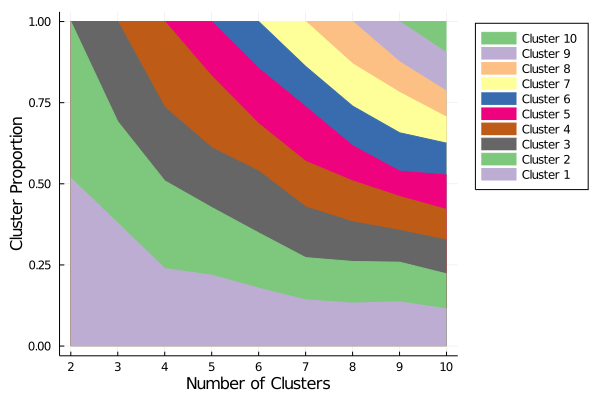

In [238]:
cum_plot(plotmat)

In [239]:
savefig("figures/bal_kmeans_portfolio_$upper")

#### Number of Clusters

* https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

using methods above, determined that 7 clusters

In [240]:
km_clusters = 7

7

In [241]:
km_assignments[km_clusters-1] # is 7 clusters

499-element Array{Int64,1}:
 3
 5
 2
 5
 1
 3
 7
 3
 5
 4
 6
 6
 2
 4
 4
 7
 5
 1
 2
 7
 4
 4
 4
 6
 2
 6
 4
 2
 6
 1
 5
 1
 3
 7
 4
 5
 3
 5
 6
 4
 5
 3
 4
 4
 3
 2
 7
 2
 ⋮
 4
 5
 7
 7
 1
 5
 6
 5
 1
 3
 6
 6
 3
 4
 2
 5
 3
 5
 1
 4
 2
 2
 3
 5
 1
 1
 5
 6
 6
 3
 1
 1
 2
 1
 1
 2
 2
 1
 6
 7
 4
 1
 1
 6
 7
 2
 1

#### Verifying Clusters

In [242]:
y_1h = map(x-> if (x == "L") 1 elseif (x == "R") 2 else 3 end , y[train])
collect(zip(km_assignments[km_clusters-1], y_1h))

499-element Array{Tuple{Int64,Int64},1}:
 (3, 1)
 (5, 1)
 (2, 1)
 (5, 2)
 (1, 1)
 (3, 2)
 (7, 2)
 (3, 2)
 (5, 1)
 (4, 1)
 (6, 2)
 (6, 2)
 (2, 1)
 (4, 1)
 (4, 1)
 (7, 1)
 (5, 2)
 (1, 1)
 (2, 1)
 (7, 2)
 (4, 2)
 (4, 1)
 (4, 1)
 (6, 2)
 (2, 1)
 (6, 2)
 (4, 1)
 (2, 1)
 (6, 2)
 (1, 2)
 (5, 2)
 (1, 3)
 (3, 1)
 (7, 2)
 (4, 1)
 (5, 2)
 (3, 1)
 (5, 1)
 (6, 2)
 (4, 2)
 (5, 3)
 (3, 1)
 (4, 2)
 (4, 1)
 (3, 2)
 (2, 1)
 (7, 2)
 (2, 1)
 ⋮
 (4, 1)
 (5, 2)
 (7, 1)
 (7, 2)
 (1, 3)
 (5, 2)
 (6, 2)
 (5, 3)
 (1, 2)
 (3, 2)
 (6, 2)
 (6, 2)
 (3, 2)
 (4, 1)
 (2, 1)
 (5, 2)
 (3, 2)
 (5, 2)
 (1, 1)
 (4, 1)
 (2, 1)
 (2, 1)
 (3, 1)
 (5, 1)
 (1, 2)
 (1, 2)
 (5, 2)
 (6, 2)
 (6, 2)
 (3, 2)
 (1, 1)
 (1, 1)
 (2, 1)
 (1, 2)
 (1, 2)
 (2, 1)
 (2, 1)
 (1, 1)
 (6, 2)
 (7, 2)
 (4, 1)
 (1, 1)
 (1, 1)
 (6, 2)
 (7, 2)
 (2, 1)
 (1, 1)

In [243]:
mutualinfo(km_assignments[km_clusters-1], y_1h)

0.17217083630640004

In [244]:
vmeasure(km_assignments[km_clusters-1], y_1h)

0.17217083630639998

In [245]:
randindex(km_assignments[km_clusters-1], y_1h)

(0.09238207444103792, 0.5917054993521179, 0.4082945006478821, 0.18341099870423577)

In [246]:
varinfo(km_assignments[km_clusters-1], y_1h)

2.3629758146848374

In [247]:
a = X[train,1].*X[train,2]
b = X[train,3].*X[train,4]

499-element Array{Float64,1}:
  8.0
 12.0
  3.0
 20.0
  4.0
  9.0
  8.0
 12.0
 12.0
  4.0
 25.0
  9.0
  4.0
  3.0
  2.0
  4.0
 10.0
  2.0
  2.0
  5.0
  8.0
  4.0
  4.0
 20.0
  2.0
 12.0
  4.0
 10.0
 16.0
  4.0
  6.0
  2.0
 10.0
 15.0
  8.0
 25.0
  4.0
 10.0
 20.0
 15.0
 10.0
  6.0
 10.0
  8.0
 15.0
  1.0
 10.0
  9.0
  ⋮
  5.0
 25.0
  8.0
 12.0
  2.0
 15.0
 15.0
  9.0
  6.0
 12.0
 12.0
 16.0
 20.0
  4.0
  3.0
 25.0
 20.0
 12.0
  1.0
 15.0
  2.0
  1.0
  3.0
  5.0
  6.0
  6.0
 20.0
  9.0
 20.0
 16.0
  2.0
  2.0
  6.0
  4.0
  4.0
  4.0
  6.0
  3.0
 20.0
  8.0
  8.0
  2.0
  4.0
  8.0
  8.0
  3.0
  1.0

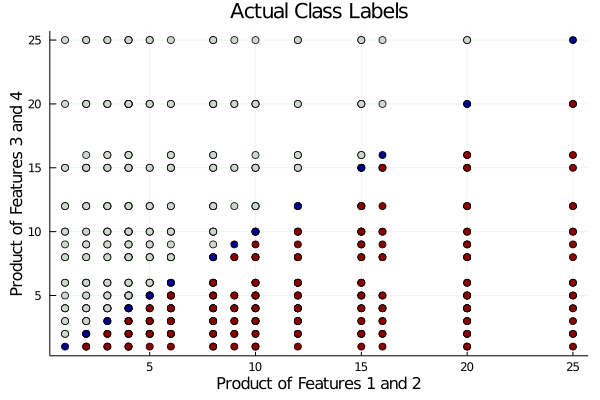

In [248]:
scatter(a,b, color=y_1h, palette=:redsblues, title="Actual Class Labels", 
            xlabel="Product of Features 1 and 2", 
            ylabel="Product of Features 3 and 4", leg=false)

In [249]:
savefig("figures/bal_km_pair_labels")

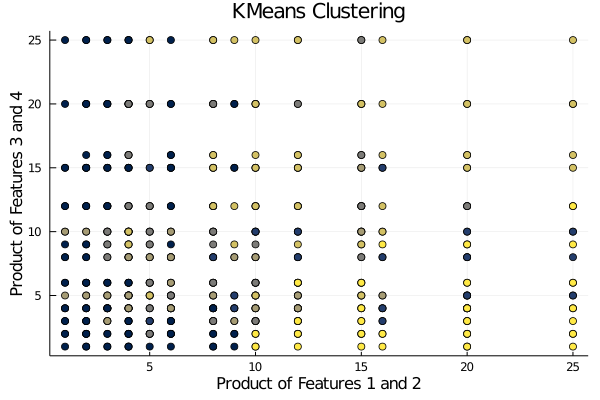

In [250]:
scatter(a,b, color=km_assignments[km_clusters-1], palette=cgrad(:cividis, 7, categorical = true), 
            title="KMeans Clustering", 
            xlabel="Product of Features 1 and 2", 
            ylabel="Product of Features 3 and 4", leg=false)

In [251]:
savefig("figures/bal_km_pair_clusters")

### Expectation Maximization

* https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
* https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#sphx-glr-auto-examples-mixture-plot-gmm-pdf-py
* https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py
* https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py
* https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
* https://github.com/JuliaPy/PyCall.jl

In [252]:
sklearn_m = pyimport("sklearn.mixture")

PyObject <module 'sklearn.mixture' from '/home/andrew/miniconda3/envs/julia/lib/python3.7/site-packages/sklearn/mixture/__init__.py'>

In [253]:
upper = 10
k_range = 2:upper
bics = []
sils = []
ls = []
sil_means = []
em_assignments = []

for i in k_range
    println("Gaussians = $i")
    clf = sklearn_m.GaussianMixture(n_components=i, covariance_type="full", random_state=RNG)
    labels = clf.fit_predict(train_data) .+ 1; # indexing issues from python to julia functions
    
    d = countmap(labels)
    k = d |> keys
    v = d |> values
    l = sort(collect(zip(k,v)), by=x->x[1])
    @show l
    
    s = silhouettes(labels, dist_mat(train_data))
    println("silhouette: $(mean(s))")
    
    bayes_ic = clf.bic(train_data)
    @show bayes_ic
    
    push!(ls, l)
    push!(sils, s)
    push!(sil_means, mean(s))
    push!(bics, bayes_ic)
    push!(em_assignments, labels)
    println("")
end

Gaussians = 2
l = [(1, 232), (2, 267)]
silhouette: 0.18920209509547037
bayes_ic = 7138.894207621482

Gaussians = 3
l = [(1, 168), (2, 206), (3, 125)]
silhouette: 0.16623841429712685
bayes_ic = 7168.855258079706

Gaussians = 4
l = [(1, 133), (2, 137), (3, 109), (4, 120)]
silhouette: 0.16590998926445596
bayes_ic = 7200.617369359455

Gaussians = 5
l = [(1, 94), (2, 102), (3, 82), (4, 104), (5, 117)]
silhouette: 0.1740440139170863
bayes_ic = 7240.572001895403

Gaussians = 6
l = [(1, 92), (2, 67), (3, 67), (4, 85), (5, 78), (6, 110)]
silhouette: 0.17994303337538567
bayes_ic = 7314.308474479086

Gaussians = 7
l = [(1, 71), (2, 62), (3, 53), (4, 103), (5, 102), (6, 52), (7, 56)]
silhouette: 0.08746486125676677
bayes_ic = 4981.2455746346395

Gaussians = 8
l = [(1, 60), (2, 67), (3, 51), (4, 61), (5, 69), (6, 67), (7, 76), (8, 48)]
silhouette: 0.19774728071651013
bayes_ic = 7454.791092654708

Gaussians = 9
l = [(1, 58), (2, 58), (3, 49), (4, 51), (5, 77), (6, 46), (7, 58), (8, 40), (9, 62)]
sil

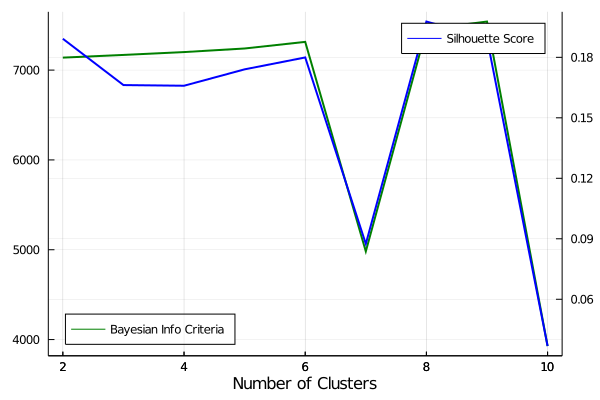

In [254]:
plot(k_range, bics, legend=:bottomleft, label="Bayesian Info Criteria", color=:green, lw=2)
xlabel!("Number of Clusters")
plot!(twinx(),k_range, sil_means, legend=:topright, label="Silhouette Score", color=:blue, lw=2)

In [255]:
savefig("figures/bal_em_metrics_$upper")

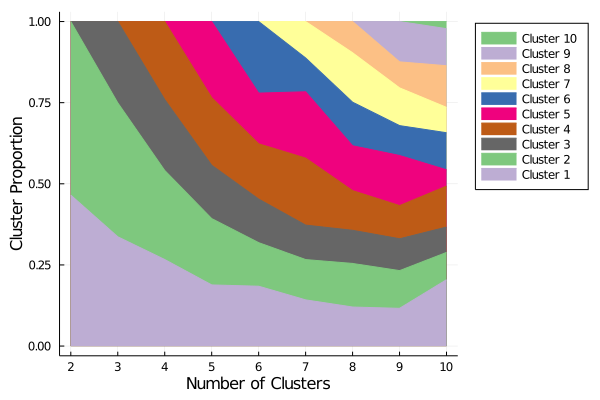

In [256]:
mat = prepare_portfolio(ls)
plotmat = cum_columns(mat, normalize=true)
cum_plot(plotmat)

In [257]:
savefig("figures/bal_em_portfolio_$upper")

#### Number of Clusters

* https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

#### Verifying Clusters

In [258]:
em_clusters = 4

4

In [259]:
collect(zip(em_assignments[em_clusters-1], y_1h))

499-element Array{Tuple{Int64,Int64},1}:
 (3, 1)
 (1, 1)
 (3, 1)
 (1, 2)
 (2, 1)
 (2, 2)
 (4, 2)
 (3, 2)
 (1, 1)
 (3, 1)
 (4, 2)
 (2, 2)
 (1, 1)
 (2, 1)
 (1, 1)
 (4, 1)
 (1, 2)
 (2, 1)
 (3, 1)
 (4, 2)
 (2, 2)
 (2, 1)
 (1, 1)
 (4, 2)
 (1, 1)
 (4, 2)
 (2, 1)
 (3, 1)
 (4, 2)
 (2, 2)
 (1, 2)
 (2, 3)
 (3, 1)
 (4, 2)
 (3, 1)
 (4, 2)
 (3, 1)
 (1, 1)
 (4, 2)
 (1, 2)
 (1, 3)
 (3, 1)
 (1, 2)
 (3, 1)
 (2, 2)
 (3, 1)
 (4, 2)
 (1, 1)
 ⋮
 (2, 1)
 (1, 2)
 (3, 1)
 (4, 2)
 (2, 3)
 (4, 2)
 (2, 2)
 (2, 3)
 (2, 2)
 (4, 2)
 (2, 2)
 (4, 2)
 (4, 2)
 (3, 1)
 (3, 1)
 (4, 2)
 (4, 2)
 (4, 2)
 (2, 1)
 (1, 1)
 (3, 1)
 (1, 1)
 (3, 1)
 (1, 1)
 (2, 2)
 (2, 2)
 (1, 2)
 (2, 2)
 (4, 2)
 (4, 2)
 (2, 1)
 (2, 1)
 (3, 1)
 (2, 2)
 (2, 2)
 (3, 1)
 (3, 1)
 (2, 1)
 (4, 2)
 (4, 2)
 (3, 1)
 (2, 1)
 (1, 1)
 (2, 2)
 (3, 2)
 (1, 1)
 (1, 1)

In [260]:
mutualinfo(em_assignments[em_clusters-1], y_1h)

0.12195600091578891

In [261]:
vmeasure(em_assignments[em_clusters-1], y_1h)

0.1219560009157888

In [262]:
randindex(em_assignments[em_clusters-1], y_1h)

(0.11397896390734409, 0.5880033158686852, 0.41199668413131485, 0.17600663173737033)

In [189]:
varinfo(em_assignments[em_clusters-1], y_1h)

1.3823260372569925

In [263]:
em_assignments[em_clusters-1]

499-element Array{Int64,1}:
 3
 1
 3
 1
 2
 2
 4
 3
 1
 3
 4
 2
 1
 2
 1
 4
 1
 2
 3
 4
 2
 2
 1
 4
 1
 4
 2
 3
 4
 2
 1
 2
 3
 4
 3
 4
 3
 1
 4
 1
 1
 3
 1
 3
 2
 3
 4
 1
 ⋮
 2
 1
 3
 4
 2
 4
 2
 2
 2
 4
 2
 4
 4
 3
 3
 4
 4
 4
 2
 1
 3
 1
 3
 1
 2
 2
 1
 2
 4
 4
 2
 2
 3
 2
 2
 3
 3
 2
 4
 4
 3
 2
 1
 2
 3
 1
 1

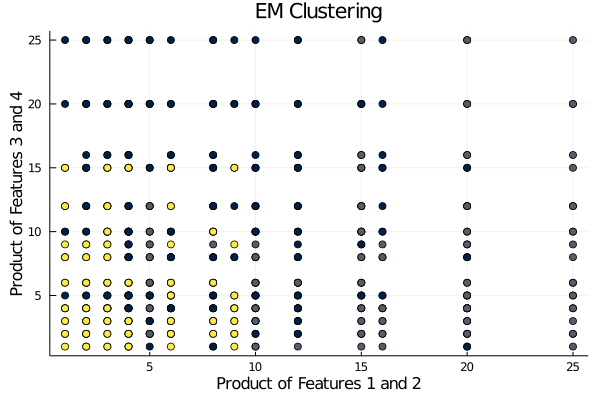

In [264]:
scatter(a,b, color=em_assignments[em_clusters-1], palette=cgrad(:cividis, em_clusters, categorical = true), 
            title="EM Clustering", 
            xlabel="Product of Features 1 and 2", 
            ylabel="Product of Features 3 and 4", leg=false)

In [265]:
savefig("figures/bal_em_pair_clusters")

# Dimensionality Reduction
Apply the dimensionality reduction algorithms to the two datasets and describe what you see.


### PCA

In [325]:
info("PCA")

Principal component analysis. Learns a linear transformation to
project the data  on a lower dimensional space while preserving most of the initial
variance.

→ based on [MultivariateStats](https://github.com/JuliaStats/MultivariateStats.jl).
→ do `@load PCA pkg="MultivariateStats"` to use the model.
→ do `?PCA` for documentation.
(name = "PCA",
 package_name = "MultivariateStats",
 is_supervised = false,
 docstring = "Principal component analysis. Learns a linear transformation to\nproject the data  on a lower dimensional space while preserving most of the initial\nvariance.\n\n→ based on [MultivariateStats](https://github.com/JuliaStats/MultivariateStats.jl).\n→ do `@load PCA pkg=\"MultivariateStats\"` to use the model.\n→ do `?PCA` for documentation.",
 hyperparameter_ranges = (nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Int64", "Symbol", "Float64", "Union{Nothing, Array{Float64,1}, Real}"),
 hyperparameters = (:maxoutdim, :method, :pratio, :mean),
 implemented_me

In [326]:
model = @load PCA pkg="MultivariateStats" 
mach = machine(model, X)
MLJ.fit!(mach, rows=train)

┌ Info: Training Machine{PCA} @840.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


Machine{PCA} @840 trained 1 time.
  args: 
    1:	Source @664 ⏎ `Table{AbstractArray{Continuous,1}}`


In [327]:
report(mach)

(indim = 4,
 outdim = 4,
 tprincipalvar = 8.071492382355073,
 tresidualvar = -1.7763568394002505e-15,
 tvar = 8.071492382355071,
 mean = [2.9839679358717435, 2.9799599198396796, 2.993987975951904, 2.9899799599198396],
 principalvars = [2.0755800255789763, 2.0409647612212742, 2.024851486767648, 1.930096108787173],)

In [328]:
report(mach)[:principalvars]

4-element Array{Float64,1}:
 2.0755800255789763
 2.0409647612212742
 2.024851486767648
 1.930096108787173

In [329]:
fitted_params(mach)[1]

4×4 Array{Float64,2}:
 0.832496   0.159874   0.48414       0.216792
 0.228322   0.122959  -0.000743831  -0.965789
 0.159663   0.77743   -0.592699      0.137181
 0.478881  -0.595755  -0.643674      0.0378595

In [330]:
d = MLJ.transform(mach, rows=train)

,x1,x2,x3,x4
,Float64,Float64,Float64,Float64
1,-0.0672146,1.49988,0.0479648,-0.881143
2,2.39588,-0.149316,0.321597,-0.509021
3,0.993495,-1.14534,1.66578,-2.00382
4,2.03024,1.03667,-0.861569,2.66271
5,-0.843186,-0.300902,1.23485,0.776074
6,-1.41299,-0.193057,-0.97129,-1.41405
7,-1.77874,-1.93512,-1.02003,1.384
8,-0.705786,-0.665852,-1.61571,-2.34198
9,2.16755,-0.272276,0.322341,0.456769


In [331]:
scitype(d)

Table{AbstractArray{Continuous,1}}

In [332]:
report(mach)[:mean]

4-element Array{Float64,1}:
 2.9839679358717435
 2.9799599198396796
 2.993987975951904
 2.9899799599198396

In [333]:
# plot explained variance
max_dims=4
ex_vars = []
err_vars = []

for i in 1:max_dims
    model.maxoutdim = i
    mach = machine(model, X)
    MLJ.fit!(mach, rows=train) 
    d = MLJ.transform(mach, rows=train)
    
    r = mach.report
    push!(ex_vars, r[:tprincipalvar] / r[:tvar])   
    
    sqerr = (train_data - (Array(d) * fitted_params(mach)[1]' .+ r[:mean]')).^2 |> sum
    push!(err_vars, sqerr) 
    
end


┌ Info: Training Machine{PCA} @042.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Info: Training Machine{PCA} @279.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Info: Training Machine{PCA} @809.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Info: Training Machine{PCA} @375.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


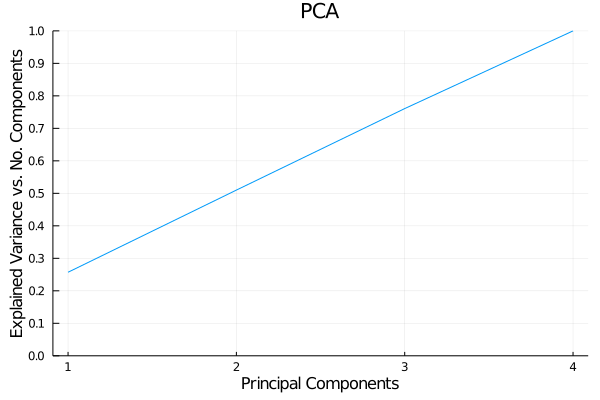

In [334]:
#elbow method
plot(1:max_dims, ex_vars, label="Explained Variance", legend=false)
ylims!(0,1)
yticks!(0:0.1:1)
xticks!(1:1:4)
xlabel!("Principal Components")
ylabel!("Explained Variance vs. No. Components")
title!("PCA")

In [335]:
savefig("figures/bal_pca_explained_variance")

weak elbow, that has low explained variance. probably going to opt for around 20 after which it doesn't improve quickly

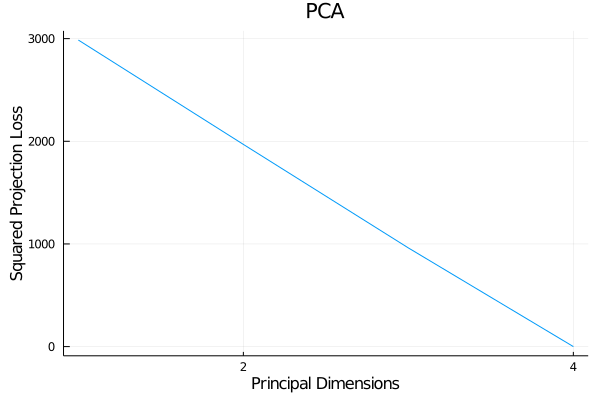

In [336]:
plot(1:max_dims, err_vars, legend=false)
xlabel!("Principal Dimensions")
ylabel!("Squared Projection Loss")
xticks!(1:max_dims)
xticks!(2:2:30)
title!("PCA")

In [337]:
savefig("figures/bal_pca_sqerr")

visualize top 2 or 3 principal components

In [338]:
sum(mach.report[:principalvars][1:2]) / sum(mach.report[:principalvars])

0.5100103663356416

In [339]:
model.maxoutdim = 3
mach = machine(model, X)
MLJ.fit!(mach, rows=train) 
data_trans = MLJ.transform(mach, rows=train)

┌ Info: Training Machine{PCA} @018.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


,x1,x2,x3
,Float64,Float64,Float64
1,-0.0672146,1.49988,0.0479648
2,2.39588,-0.149316,0.321597
3,0.993495,-1.14534,1.66578
4,2.03024,1.03667,-0.861569
5,-0.843186,-0.300902,1.23485
6,-1.41299,-0.193057,-0.97129
7,-1.77874,-1.93512,-1.02003
8,-0.705786,-0.665852,-1.61571
9,2.16755,-0.272276,0.322341


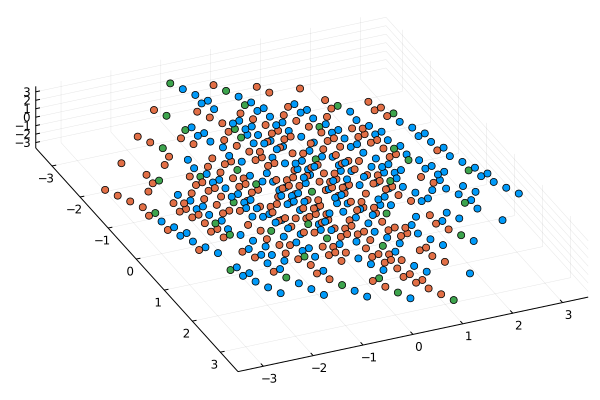

In [340]:
scatter(data_trans[:,1],data_trans[:,2],data_trans[:,3], leg=false, color=y_1h_km, camera=(60,80))

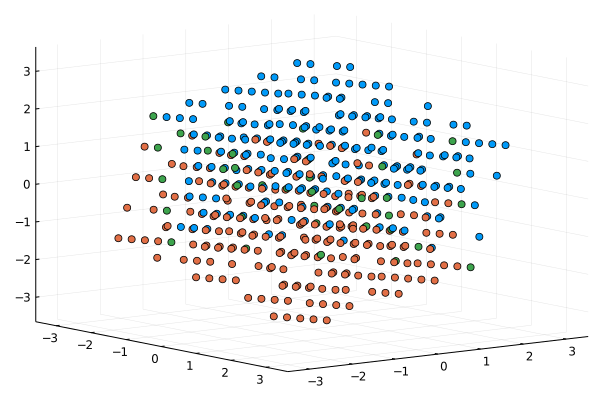

In [341]:
scatter(data_trans[:,1],data_trans[:,2],data_trans[:,3], leg=false, c=y_1h_km, camera=(50,30))

In [342]:
savefig("figures/bal_pca_$(model.maxoutdim)_comps_3D")

In [343]:
PCA_best_comps = 3;

In [344]:
model.maxoutdim = PCA_best_comps
mach = machine(model, X)
MLJ.fit!(mach, rows=train) 
PCA_data = MLJ.transform(mach, rows=train)

┌ Info: Training Machine{PCA} @504.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


,x1,x2,x3
,Float64,Float64,Float64
1,-0.0672146,1.49988,0.0479648
2,2.39588,-0.149316,0.321597
3,0.993495,-1.14534,1.66578
4,2.03024,1.03667,-0.861569
5,-0.843186,-0.300902,1.23485
6,-1.41299,-0.193057,-0.97129
7,-1.77874,-1.93512,-1.02003
8,-0.705786,-0.665852,-1.61571
9,2.16755,-0.272276,0.322341


In [347]:
mach.report

(indim = 4,
 outdim = 3,
 tprincipalvar = 6.141396273567899,
 tresidualvar = 1.930096108787172,
 tvar = 8.071492382355071,
 mean = [2.9839679358717435, 2.9799599198396796, 2.993987975951904, 2.9899799599198396],
 principalvars = [2.0755800255789763, 2.0409647612212742, 2.024851486767648],)

In [349]:
fitted_params(mach)[1]

4×3 Array{Float64,2}:
 0.832496   0.159874   0.48414
 0.228322   0.122959  -0.000743831
 0.159663   0.77743   -0.592699
 0.478881  -0.595755  -0.643674

### ICA

In [319]:
info("ICA")

Independent component analysis.
→ based on [MultivariateStats](https://github.com/JuliaStats/MultivariateStats.jl).
→ do `@load ICA pkg="MultivariateStats"` to use the model.
→ do `?ICA` for documentation.
(name = "ICA",
 package_name = "MultivariateStats",
 is_supervised = false,
 docstring = "Independent component analysis.\n→ based on [MultivariateStats](https://github.com/JuliaStats/MultivariateStats.jl).\n→ do `@load ICA pkg=\"MultivariateStats\"` to use the model.\n→ do `?ICA` for documentation.",
 hyperparameter_ranges = (nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Int64", "Symbol", "Symbol", "Bool", "Int64", "Real", "Union{Nothing, Array{_s41,2} where _s41<:Real}", "Union{Nothing, Array{Float64,1}, Real}"),
 hyperparameters = (:k, :alg, :fun, :do_whiten, :maxiter, :tol, :winit, :mean),
 implemented_methods = [:clean!, :fit, :fitted_params, :transform],
 is_pure_julia = true,
 is_wrapper = false,
 load_path = "MLJMultivariat

In [350]:
model = @load ICA pkg="MultivariateStats" 
model.k = 4
model.do_whiten = false
model.maxiter= 1000000
model.tol = 10^-1.5
mach = machine(model, X)
MLJ.fit!(mach, rows=train)

┌ Info: Training Machine{ICA} @867.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


Machine{ICA} @867 trained 1 time.
  args: 
    1:	Source @772 ⏎ `Table{AbstractArray{Continuous,1}}`


In [351]:
report(mach)

(indim = 4,
 outdim = 4,
 mean = [2.9839679358717435, 2.9799599198396796, 2.993987975951904, 2.9899799599198396],)

In [352]:
mach.fitresult.W, mach.fitresult.mean

([0.08464684302371998 0.08618329028444363 0.7196917636429839 0.6837039694095081; 0.07828169460942061 0.03952056245323931 -0.6933862356821667 0.7152101995909819; 0.9932333531968125 0.0035145434175505386 -0.00717328361792993 -0.11586068394463363; -0.01394253752408142 0.9954889319343005 -0.03475395679781863 -0.08717542389109335], [2.9839679358717435, 2.9799599198396796, 2.993987975951904, 2.9899799599198396])

In [353]:
data_trans = MLJ.transform(mach, rows=train)

,x1,x2,x3,x4
,Float64,Float64,Float64,Float64
1,1.09422,-0.940284,-0.668554,0.710249
2,0.24239,1.21955,0.708495,2.01917
3,-1.7365,0.170365,-0.655483,2.36957
4,1.99401,1.10801,2.77431,-0.358185
5,-1.04882,-1.02635,0.732565,-0.48845
6,-0.0822545,-0.120676,-2.13552,-0.628474
7,-1.32428,0.752736,-0.0829405,-2.74542
8,-0.0179154,0.914333,-2.86366,-0.000438966
9,0.164109,1.18003,1.40188,1.30396


In [354]:
kurtosis(convert(Array, data_trans))

-0.965113778772547

In [362]:
max_comps = 4
model.maxiter= 1000000
kurts = []
best_kurt = -Inf
best_ica_mach = nothing
best_i = 0
err_vars = []

for i in 3:max_comps
    @show i
    model.k = i
    model.do_whiten = false
    model.maxiter= 1000000
    model.tol = 0.7
    mach = machine(model, X)
    MLJ.fit!(mach, rows=train)
    d = MLJ.transform(mach, rows=train)
    r = mach.report
    krtoes = kurtosis(convert(Array, d))
    push!(kurts, krtoes)
    
    sqerr = (train_data - (Array(d) * mach.fitresult.W' .+ mach.fitresult.mean')).^2 |> sum
    push!(err_vars, sqerr) 
    
    if krtoes > best_kurt
        best_ica_mach = mach
        best_i = i
        best_kurt = krtoes
    end    
end

i = 3
i = 4


┌ Info: Training Machine{ICA} @781.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Info: Training Machine{ICA} @937.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


In [363]:
kurts

2-element Array{Any,1}:
 -1.035401807205819
 -0.5720619894621213

In [364]:
best_i, best_kurt

(4, -0.5720619894621213)

In [365]:
best_ica_mach

Machine{ICA} @937 trained 1 time.
  args: 
    1:	Source @900 ⏎ `Table{AbstractArray{Continuous,1}}`


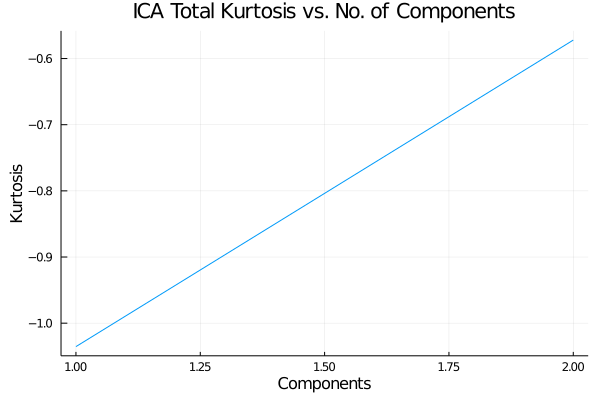

In [366]:
plot(kurts, legend=false, xlabel="Components", ylabel="Kurtosis", title="ICA Total Kurtosis vs. No. of Components")

In [367]:
savefig("figures/bal_ica_kurtosis")

In [368]:
plot(1:max_comps, err_vars, legend=false)
xlabel!("Independent Dimensions")
ylabel!("Squared Projection Loss")
xticks!(1:max_dims)
# ylims!(0.5, 1)

BoundsError: BoundsError: attempt to access 2-element Array{Float64,1} at index [1:4]

In [369]:
savefig("figures/bal_ica_sqerr")

LoadError: BoundsError: attempt to access 2-element Array{Float64,1} at index [1:4]

In [370]:
ica_trans = MLJ.transform(best_ica_mach, rows=train)

,x1,x2,x3,x4
,Float64,Float64,Float64,Float64
1,-1.26567,0.216172,0.906859,0.749545
2,0.806124,-0.68219,2.07281,-0.844561
3,1.12543,1.93448,1.84897,-0.813305
4,-0.474319,-3.36819,0.0690037,-1.20599
5,-0.431328,0.738518,-0.990458,-1.10281
6,0.239276,1.05422,-0.389766,1.91212
7,1.33266,-0.0327734,-2.83014,0.278863
8,1.18315,1.00425,0.45919,2.53331
9,0.716904,-1.11492,1.29259,-1.28732


In [371]:
best_component = 0
best_k_so_far = 0
second_best = 0
for i in 1:size(ica_trans)[2]
    curr_k = kurtosis(ica_trans[:,i])
    @show i curr_k
    if curr_k > best_k_so_far
        second_best = best_component
        best_component = i
        best_k_so_far = curr_k
    end
    
end

i = 1
curr_k = -0.757810973006158
i = 2
curr_k = -0.4514284410729701
i = 3
curr_k = -0.5849642242338939
i = 4
curr_k = -0.48782844361152744


In [375]:
weight_mat = best_ica_mach.fitresult.W[:,1]

# https://stackoverflow.com/questions/3989016/how-to-find-all-positions-of-the-maximum-value-in-a-list
m = sort!(collect(zip((abs.(weight_mat)), 1:size(weight_mat)[1])), by=x->x[1], rev=true)

4-element Array{Tuple{Float64,Int64},1}:
 (0.8546525600543586, 4)
 (0.5063909223400451, 3)
 (0.08922033401768578, 2)
 (0.07195114566080266, 1)

largest weighted features above deal with the number of carbon bonds and the number of halogen atoms in the molecule. these are actually largely independent, e.g. one is not a physical property that could be influenced by the other

In [373]:
marginalscatter(ica_trans[:,best_component],ica_trans[:,second_best], leg=false, c=y_1h)

LoadError: BoundsError: attempt to access data frame with 4 columns
  at index [0]

In [ ]:
savefig("figures/bal_ica_pair")

In [ ]:
pairplot(data_trans, y_1h, c=1:6)

In [380]:
model = @load ICA pkg="MultivariateStats" 
model.k = 3
model.do_whiten = false
model.maxiter= 1000000
model.tol = 6e-1
best_ica_mach = machine(model, X)
MLJ.fit!(best_ica_mach, rows=train)
ICA_data = MLJ.transform(best_ica_mach, rows=train)

┌ Info: Training Machine{ICA} @028.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


,x1,x2,x3
,Float64,Float64,Float64
1,0.887774,-1.06545,-0.730037
2,-1.34191,-0.134882,0.540681
3,-0.34165,1.83579,-0.902162
4,-1.04246,-1.95555,2.84851
5,1.06055,1.04635,0.739048
6,0.137714,0.00483524,-2.06977
7,-0.574884,1.17903,0.166432
8,-0.944609,-0.0515563,-2.83426
9,-1.24746,-0.0766545,1.29606


In [381]:
mach.report

(indim = 4,
 outdim = 4,
 mean = [2.9839679358717435, 2.9799599198396796, 2.993987975951904, 2.9899799599198396],)

In [382]:
fitted_params(mach)

LoadError: MethodError: no method matching projection(::ICA{Float64})
Closest candidates are:
  projection(!Matched::PCA) at /home/andrew/.julia/packages/MultivariateStats/BYMwD/src/pca.jl:33
  projection(!Matched::PPCA) at /home/andrew/.julia/packages/MultivariateStats/BYMwD/src/ppca.jl:16
  projection(!Matched::KernelPCA) at /home/andrew/.julia/packages/MultivariateStats/BYMwD/src/kpca.jl:46
  ...

### Randomized Projections
* https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.SparseRandomProjection.html#sklearn.random_projection.SparseRandomProjection

In [383]:
sklearn_rp = pyimport("sklearn.random_projection") # may be necessary to run this

PyObject <module 'sklearn.random_projection' from '/home/andrew/miniconda3/envs/julia/lib/python3.7/site-packages/sklearn/random_projection.py'>

In [384]:
RP = sklearn_rp.SparseRandomProjection(n_components=4, random_state=RNG)

PyObject SparseRandomProjection(n_components=4, random_state=133)

In [385]:
X_RP = RP.fit_transform(train_data)

499×4 Array{Float64,2}:
 -1.41421    0.707107     -2.12132      -2.82843
  0.707107   4.24264      -1.41421      -2.82843
  1.41421    4.24264       0.0          -3.53553
 -0.707107   2.82843      -2.82843      -0.707107
  0.0        2.12132      -0.707107     -1.41421
  0.0        0.707107     -3.53553      -2.82843
  1.41421    2.12132      -3.53553      -0.707107
  0.707107   1.41421      -4.24264      -3.53553
  0.707107   4.24264      -1.41421      -2.12132
 -2.12132    0.707107     -0.707107     -3.53553
  0.0        2.12132      -4.94975      -0.707107
  0.0        2.12132      -2.12132      -1.41421
  2.12132    5.65685       0.0          -2.12132
 -1.41421    0.707107     -0.707107     -2.12132
 -0.707107   2.82843       1.41421      -1.41421
  2.12132    3.53553      -2.12132      -2.82843
  2.12132    5.65685      -1.41421      -0.707107
 -0.707107   1.41421       1.11022e-16  -2.12132
 -0.707107   1.41421       1.11022e-16  -2.82843
  2.82843    4.94975      -2.12132      -

In [386]:
(train_data - convert(Array, X_RP * RP.components_)).^2 |> mean

6.672970941883768

In [401]:
# plot reconstruction error
max_dims=4
err_vars_all = []

for z in rand(1:1000, 7)
    err_vars = []

    for i in 1:max_dims
        RP = sklearn_rp.SparseRandomProjection(n_components=i, random_state=z)
        X_RP = RP.fit_transform(train_data)
        sqerr = (train_data - convert(Array, X_RP * RP.components_)).^2 |> sum

        push!(err_vars, sqerr)   
    end
    push!(err_vars_all, err_vars)
end

# https://stackoverflow.com/questions/36566844/pca-projection-and-reconstruction-in-scikit-learn

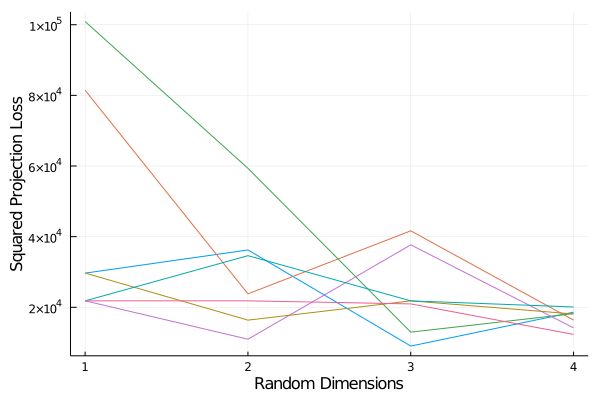

In [404]:
plot(1:max_dims, err_vars_all, legend=false)
xlabel!("Random Dimensions")
ylabel!("Squared Projection Loss")
xticks!(1:1:max_dims)

In [405]:
savefig("figures/bal_rp_sqerr")

In [406]:
RP = sklearn_rp.SparseRandomProjection(n_components=3, random_state=RNG)

PyObject SparseRandomProjection(n_components=3, random_state=133)

In [407]:
RP_data = RP.fit_transform(train_data)

499×3 Array{Float64,2}:
 -4.89898  -0.816497      -7.34847
 -5.71548  -4.89898       -9.79796
 -3.26599  -4.89898       -6.53197
 -7.34847  -3.26599      -11.431
 -3.26599  -2.44949       -5.71548
 -4.89898  -0.816497      -5.71548
 -4.89898  -2.44949       -5.71548
 -5.71548  -1.63299       -6.53197
 -5.71548  -4.89898       -9.79796
 -4.08248  -0.816497      -7.34847
 -8.16497  -2.44949      -10.6145
 -4.89898  -2.44949       -7.34847
 -4.08248  -6.53197       -8.16497
 -3.26599  -0.816497      -5.71548
 -2.44949  -3.26599       -6.53197
 -4.08248  -4.08248       -5.71548
 -5.71548  -6.53197       -9.79796
 -2.44949  -1.63299       -4.89898
 -2.44949  -1.63299       -4.89898
 -4.89898  -5.71548       -7.34847
 -4.89898  -0.816497      -7.34847
 -4.08248   1.11022e-16   -6.53197
 -4.08248  -0.816497      -7.34847
 -7.34847  -2.44949       -8.98146
 -2.44949  -4.89898       -6.53197
 -5.71548  -2.44949       -7.34847
 -4.08248   1.11022e-16   -6.53197
 -5.71548  -6.53197       -9.79796

### Probabilistic PCA
* https://multivariatestatsjl.readthedocs.io/en/stable/kpca.html

In [408]:
models("MultivariateStats")

11-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = FactorAnalysis, package_name = MultivariateStats, ... )
 (name = ICA, package_name = MultivariateStats, ... )
 (name = KernelPCA, package_name = MultivariateStats, ... )
 (name = LDA, package_name = MultivariateStats, ... )
 (name = LinearRegressor, package_name = MultivariateStats, ... )
 (name = PCA, package_name = MultivariateStats, ... )
 (name = PPCA, package_name = MultivariateStats, ... )
 (name = RidgeRegressor, package_name = MultivariateStats, ... )
 (name = Subsp

In [409]:
info("PPCA")

Probabilistic principal component analysis
→ based on [MultivariateStats](https://github.com/JuliaStats/MultivariateStats.jl).
→ do `@load PPCA pkg="MultivariateStats"` to use the model.
→ do `?PPCA` for documentation.
(name = "PPCA",
 package_name = "MultivariateStats",
 is_supervised = false,
 docstring = "Probabilistic principal component analysis\n→ based on [MultivariateStats](https://github.com/JuliaStats/MultivariateStats.jl).\n→ do `@load PPCA pkg=\"MultivariateStats\"` to use the model.\n→ do `?PPCA` for documentation.",
 hyperparameter_ranges = (nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Int64", "Symbol", "Int64", "Real", "Union{Nothing, Array{Float64,1}, Real}"),
 hyperparameters = (:maxoutdim, :method, :maxiter, :tol, :mean),
 implemented_methods = [:clean!, :fit, :fitted_params, :transform],
 is_pure_julia = true,
 is_wrapper = false,
 load_path = "MLJMultivariateStatsInterface.PPCA",
 package_license = "MIT",
 package_url = "https://github.com

In [428]:
model = @load PPCA pkg="MultivariateStats"
model.maxoutdim = 3
model.method = :ml
model.maxiter= 1000000
model.tol = 6e-1

0.6

In [429]:
mach = machine(model, X)
MLJ.fit!(mach, rows=train)

┌ Info: Training Machine{PPCA} @876.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


Machine{PPCA} @876 trained 1 time.
  args: 
    1:	Source @134 ⏎ `Table{AbstractArray{Continuous,1}}`


In [430]:
report(mach)

(indim = 4,
 outdim = 3,
 tvar = 31.003029887028998,
 mean = [2.9839679358717435, 2.9799599198396796, 2.993987975951904, 2.9899799599198396],
 loadings = [0.8916746479782705 0.1498049623034823 -0.4198105673309988; 0.24455283706431993 0.1152153873916584 0.0006449950425928333; 0.17101292058266412 0.7284671075297383 0.5139445552174198; 0.5129222596160754 -0.558234350579436 0.5581460732155876],)

In [431]:
fitted_params(mach)

(projection = [-0.8324961340352901 -0.15987385626792885 0.4841402548809156; -0.22832239526492618 -0.12295940001234279 -0.000743830881397331; -0.1596631636639527 -0.7774298251161249 -0.5926988678239655; -0.47888072085395217 0.5957551536080389 -0.6436736070398195],)

In [432]:
fitted_params(mach)[1]

4×3 Array{Float64,2}:
 -0.832496  -0.159874   0.48414
 -0.228322  -0.122959  -0.000743831
 -0.159663  -0.77743   -0.592699
 -0.478881   0.595755  -0.643674

In [433]:
 0.832496   0.159874   0.48414
 0.228322   0.122959  -0.000743831
 0.159663   0.77743   -0.592699
 0.478881  -0.595755  -0.643674

LoadError: syntax: extra token "0.159874" after end of expression

In [434]:
d = MLJ.transform(mach, rows=train)

,x1,x2,x3
,Float64,Float64,Float64
1,-0.00223926,0.0440831,-0.00130977
2,0.0798186,-0.00438858,-0.00878179
3,0.0330983,-0.0336627,-0.0454872
4,0.0676373,0.0304688,0.0235267
5,-0.0280907,-0.00884386,-0.0337198
6,-0.0470737,-0.00567415,0.0265228
7,-0.0592587,-0.0568754,0.0278539
8,-0.0235133,-0.0195702,0.0441198
9,0.072212,-0.00800249,-0.0088021


In [435]:
(train_data - (Array(d) * fitted_params(mach)[1]' .+ report(mach)[:mean]')).^2 |> sum

4206.06907520176

In [446]:
# plot reconstruction error
max_dims=3
err_vars = []

for i in 1:max_dims
    model.maxoutdim = i
    mach = machine(model, X)
    MLJ.fit!(mach, rows=train) 
    d = MLJ.transform(mach, rows=train)
    r = mach.report
    
    sqerr = (train_data - (Array(d) * fitted_params(mach)[1]' .+ r[:mean]')).^2 |> sum
    push!(err_vars, sqerr) 
    
end


┌ Info: Training Machine{PPCA} @745.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Info: Training Machine{PPCA} @030.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Info: Training Machine{PPCA} @313.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


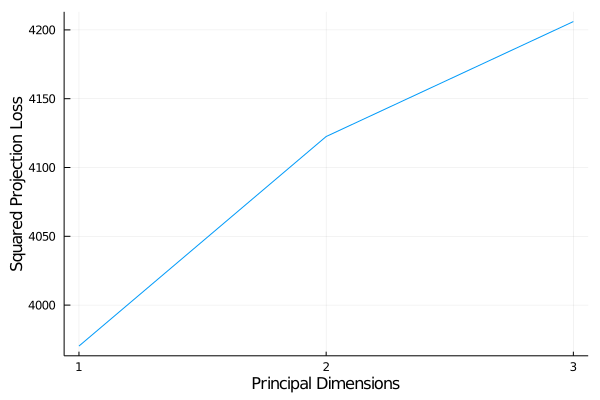

In [447]:
plot(1:max_dims, err_vars, legend=false)
xlabel!("Principal Dimensions")
ylabel!("Squared Projection Loss")
xticks!(1:max_dims)

In [441]:
savefig("figures/bal_ppca_sqerr")

In [443]:
PPCA_best_dim = 3
model.maxoutdim = PPCA_best_dim
model.method = :ml
model.maxiter= 1000000
model.tol = 6e-1

0.6

In [444]:
mach = machine(model, X)
MLJ.fit!(mach, rows=train)
PPCA_data = MLJ.transform(mach, rows=train)

┌ Info: Training Machine{PPCA} @373.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


,x1,x2,x3
,Float64,Float64,Float64
1,-0.00223926,0.0440831,-0.00130977
2,0.0798186,-0.00438858,-0.00878179
3,0.0330983,-0.0336627,-0.0454872
4,0.0676373,0.0304688,0.0235267
5,-0.0280907,-0.00884386,-0.0337198
6,-0.0470737,-0.00567415,0.0265228
7,-0.0592587,-0.0568754,0.0278539
8,-0.0235133,-0.0195702,0.0441198
9,0.072212,-0.00800249,-0.0088021


# Clustering Pt 2
Reproduce your clustering experiments, but on the data after you've run dimensionality reduction on it. Yes, that’s 16 combinations of datasets, dimensionality reduction, and clustering method. You should look at all of them, but focus on the more interesting findings in your report.

### PCA - Kmeans

In [632]:
PCA_data = convert(Array, PCA_data)

499×3 Array{Float64,2}:
 -0.0672146   1.49988      0.0479648
  2.39588    -0.149316     0.321597
  0.993495   -1.14534      1.66578
  2.03024     1.03667     -0.861569
 -0.843186   -0.300902     1.23485
 -1.41299    -0.193057    -0.97129
 -1.77874    -1.93512     -1.02003
 -0.705786   -0.665852    -1.61571
  2.16755    -0.272276     0.322341
  0.514723    2.37846      1.17503
  0.844124    0.121162    -2.47352
 -0.204642   -0.119228    -0.00152226
  1.84823    -1.82714      1.50774
 -0.934081    1.19524      1.28508
  0.342926    0.6146       2.8468
 -0.420939   -2.1838       0.0545739
  2.03013    -1.89138      0.272854
 -1.09374     0.417812     1.87778
 -0.865422    0.540772     1.87704
  0.205471   -2.98856     -0.102728
 -0.523859    1.25396      0.0494525
 -1.00274     1.84971      0.693126
 -0.170244    2.00959      1.17727
  0.0802866  -0.693182    -2.36571
  1.11879    -0.512666     2.79434
 -0.78658    -0.997816    -1.12859
 -0.546095    2.09563      0.691638
  2.94342    -1.

In [719]:
upper = 10
k_range = 2:upper
total_costs = []
sils = []
ls = []
sil_means = []
assignments = []

for i in k_range
    println("K = $i")
    model = ParallelKMeans.KMeans(k=i, rng=RNG)
    mach = machine(model, PCA_data)
    MLJ.fit!(mach)
    
#     @show report(mach) 
#     @show fitted_params(mach)
    @show mach.report.totalcost # https://github.com/PyDataBlog/ParallelKMeans.jl/blob/87ce07d10796078aacffcbea0b2e9dc0c02f25d7/src/hamerly.jl#L65
    d = countmap(mach.report.assignments)
    
    k = d |> keys
    v = d |> values
    l = sort(collect(zip(k,v)), by=x->x[1])
    @show l
    
    # https://juliastats.org/Clustering.jl/stable/validate.html
    s = silhouettes(mach.report.assignments, dist_mat(PCA_data))
    println("silhouette: $(mean(s))")
    
    push!(assignments, mach.report.assignments)
    push!(ls, l)
    push!(total_costs, mach.report.totalcost) 
    push!(sils, s)
    push!(sil_means, mean(s))
    println("")
end

K = 2
Iteration 1: Jclust = 3314.8603740918657
Iteration 2: Jclust = 2427.702779571151
Iteration 3: Jclust = 2661.785688637056
Iteration 4: Jclust = 2729.3642734579494
Iteration 5: Jclust = 2774.4326725082433
Iteration 6: Jclust = 2788.573833486555
Iteration 7: Jclust = 2751.179865294884
Iteration 8: Jclust = 2711.947593237627
Iteration 9: Jclust = 2706.2815156897545
Iteration 10: Jclust = 2706.8306822903296
Iteration 11: Jclust = 2699.2550485844267
Iteration 12: Jclust = 2691.4899299189747
Iteration 13: Jclust = 2690.4075397725546
Iteration 14: Jclust = 2679.080685014043
Iteration 15: Jclust = 2662.5031171015653
Iteration 16: Jclust = 2670.3194090840484
Iteration 17: Jclust = 2670.3194090840484
Successfully terminated with convergence.
mach.report.totalcost = 2294.2891562312752
l = 

┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @156`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @989.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


[(1, 243), (2, 256)]
silhouette: 0.2402415706241604

K = 3
Iteration 1: Jclust = 2577.437979166093
Iteration 2: Jclust = 1896.8764450637846
Iteration 3: Jclust = 2056.2576767756423
Iteration 4: Jclust = 2091.6695071159465
Iteration 5: Jclust = 2119.8078152226967
Iteration 6: Jclust = 2126.97177637791
Iteration 7: Jclust = 2128.226270788237
Iteration 8: Jclust = 2106.323398853664
Iteration 9: Jclust = 2090.959350521932
Iteration 10: Jclust = 2099.833202683528
Iteration 11: Jclust = 2099.833202683528
Successfully terminated with convergence.
mach.report.totalcost = 1830.2773958061073
l = [(1, 167), (2, 154), (3, 178)]
silhouette: 0.23561718261314557

K = 4
Iteration 1: Jclust = 2095.1207103447346
Iteration 2: Jclust = 1698.1911719552702
Iteration 3: Jclust = 1620.699049696648
Iteration 4: Jclust = 1668.9579920635297
Iteration 5: Jclust = 1642.8546371557147
Iteration 6: Jclust = 1675.3111277331545
Iteration 7: Jclust = 1687.6652977565134
Iteration 8: Jclust = 1698.6437302157299
Iteration 

┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @553`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @934.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @311`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @530.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @853`:
│ scitype(X) =

silhouette: 0.2779326411032826

K = 10
Iteration 1: Jclust = 1057.04878548649
Iteration 2: Jclust = 845.2297493948599
Iteration 3: Jclust = 757.0459762430893
Iteration 4: Jclust = 732.1294659456689
Iteration 5: Jclust = 747.4175814575665
Iteration 6: Jclust = 745.6618703469329
Iteration 7: Jclust = 747.7158207628186
Iteration 8: Jclust = 756.2513744003644
Iteration 9: Jclust = 743.2024778302844
Iteration 10: Jclust = 748.8346511103853
Iteration 11: Jclust = 749.3181186451006
Iteration 12: Jclust = 749.3181186451006
Successfully terminated with convergence.
mach.report.totalcost = 666.6380747003759
l = [(1, 55), (2, 52), (3, 44), (4, 42), (5, 48), (6, 61), (7, 56), (8, 30), (9, 52), (10, 59)]
silhouette: 0.27421280739399173



┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @998`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @702.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


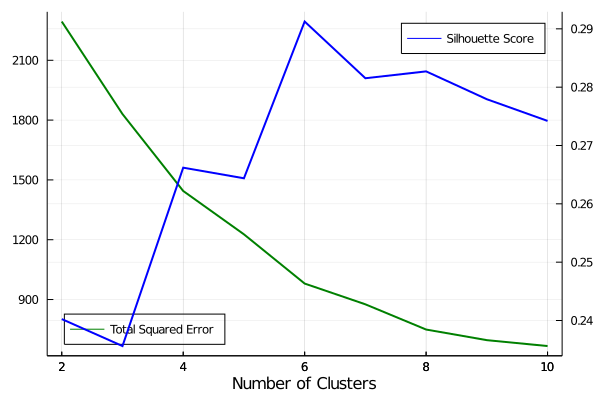

In [720]:
plot(k_range, total_costs, legend=:bottomleft, label="Total Squared Error", color=:green, lw=2)
xlabel!("Number of Clusters")
plot!(twinx(), k_range, sil_means, legend=:topright, label="Silhouette Score", color=:blue, lw=2)

In [721]:
savefig("figures/bal_pca_kmeans_metrics_$upper")

In [722]:
mat = prepare_portfolio(ls)
plotmat = cum_columns(mat, normalize=true)

10×9 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.486974  0.334669  0.246493  0.204409  …  0.118236  0.106212  0.11022
 1.0       0.643287  0.507014  0.382766     0.264529  0.240481  0.214429
 1.0       1.0       0.745491  0.613226     0.392786  0.328657  0.302605
 1.0       1.0       1.0       0.807615     0.521042  0.432866  0.386774
 1.0       1.0       1.0       1.0          0.633267  0.543086  0.482966
 1.0       1.0       1.0       1.0       …  0.721443  0.643287  0.60521
 1.0       1.0       1.0       1.0          0.841683  0.781563  0.717435
 1.0       1.0       1.0       1.0          1.0       0.87976   0.777555
 1.0       1.0       1.0       1.0          1.0       1.0       0.881764
 1.0       1.0       1.0       1.0          1.0       1.0       1.0

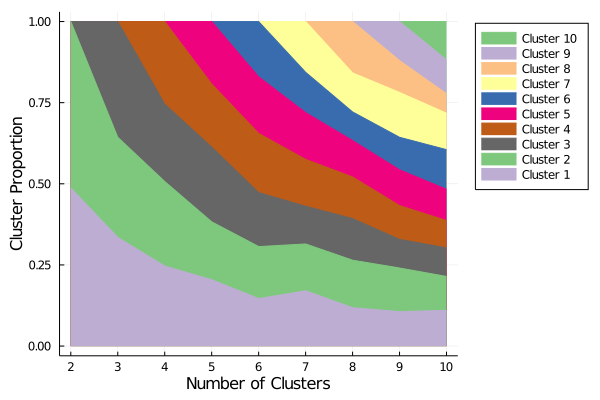

In [723]:
cum_plot(plotmat)

In [724]:
savefig("figures/bal_pca_kmeans_portfolio_$upper")

In [725]:
y_1h = map(x-> if (x == "L") 1 elseif (x == "R") 2 else 3 end , y[train])
collect(zip(assignments[5], y_1h))

499-element Array{Tuple{Int64,Int64},1}:
 (1, 1)
 (4, 1)
 (2, 1)
 (4, 2)
 (5, 1)
 (3, 2)
 (6, 2)
 (3, 2)
 (4, 1)
 (1, 1)
 (3, 2)
 (5, 2)
 (2, 1)
 (1, 1)
 (2, 1)
 (6, 1)
 (6, 2)
 (2, 1)
 (2, 1)
 (6, 2)
 (1, 2)
 (1, 1)
 (1, 1)
 (3, 2)
 (2, 1)
 (3, 2)
 (1, 1)
 (4, 1)
 (3, 2)
 (5, 2)
 (2, 2)
 (5, 3)
 (1, 1)
 (6, 2)
 (1, 1)
 (4, 2)
 (1, 1)
 (4, 1)
 (3, 2)
 (4, 2)
 (4, 3)
 (5, 1)
 (1, 2)
 (1, 1)
 (3, 2)
 (2, 1)
 (6, 2)
 (4, 1)
 ⋮
 (1, 1)
 (4, 2)
 (6, 1)
 (3, 2)
 (5, 3)
 (4, 2)
 (3, 2)
 (4, 3)
 (5, 2)
 (3, 2)
 (3, 2)
 (3, 2)
 (3, 2)
 (1, 1)
 (1, 1)
 (4, 2)
 (3, 2)
 (6, 2)
 (5, 1)
 (4, 1)
 (2, 1)
 (2, 1)
 (5, 1)
 (6, 1)
 (5, 2)
 (5, 2)
 (4, 2)
 (5, 2)
 (3, 2)
 (3, 2)
 (5, 1)
 (5, 1)
 (2, 1)
 (5, 2)
 (5, 2)
 (2, 1)
 (2, 1)
 (6, 1)
 (3, 2)
 (6, 2)
 (1, 1)
 (5, 1)
 (2, 1)
 (5, 2)
 (6, 2)
 (2, 1)
 (2, 1)

In [726]:
mutualinfo(assignments[5], y_1h)

0.16536357401902008

In [727]:
vmeasure(assignments[5], y_1h)

0.16536357401901994

In [728]:
randindex(assignments[5], y_1h)

(0.1073209989477371, 0.5955123097600824, 0.4044876902399176, 0.19102461952016483)

In [729]:
varinfo(assignments[5], y_1h)

2.2557069351459793

### PCA - EM

In [730]:
k_range = 2:upper
bics = []
sils = []
ls = []
sil_means = []
assignments = []

for i in k_range
    println("Gaussians = $i")
    clf = sklearn_m.GaussianMixture(n_components=i, covariance_type="full", random_state=RNG)
    labels = clf.fit_predict(PCA_data) .+ 1; # indexing issues from python to julia functions
    
    d = countmap(labels)
    k = d |> keys
    v = d |> values
    l = sort(collect(zip(k,v)), by=x->x[1])
    @show l
    
    s = silhouettes(labels, dist_mat(PCA_data))
    println("silhouette: $(mean(s))")
    
    bayes_ic = clf.bic(PCA_data)
    @show bayes_ic
    
    push!(ls, l)
    push!(sils, s)
    push!(sil_means, mean(s))
    push!(bics, bayes_ic)
    push!(assignments, labels)
    println("")
end

Gaussians = 2
l = [(1, 240), (2, 259)]
silhouette: 0.24657570840315116
bayes_ic = 5348.156185962057

Gaussians = 3
l = [(1, 149), (2, 173), (3, 177)]
silhouette: 0.2389539397229974
bayes_ic = 5336.736026556785

Gaussians = 4
l = [(1, 126), (2, 149), (3, 112), (4, 112)]
silhouette: 0.23337108520179012
bayes_ic = 5339.73929182486

Gaussians = 5
l = [(1, 113), (2, 99), (3, 88), (4, 80), (5, 119)]
silhouette: 0.254735414259374
bayes_ic = 5384.587973468488

Gaussians = 6
l = [(1, 76), (2, 81), (3, 91), (4, 72), (5, 103), (6, 76)]
silhouette: 0.28834050513464043
bayes_ic = 5411.733547716228

Gaussians = 7
l = [(1, 58), (2, 56), (3, 93), (4, 71), (5, 99), (6, 64), (7, 58)]
silhouette: 0.27777861764904255
bayes_ic = 5458.866889764658

Gaussians = 8
l = [(1, 67), (2, 64), (3, 56), (4, 55), (5, 88), (6, 40), (7, 62), (8, 67)]
silhouette: 0.2866103183215443
bayes_ic = 5509.33393284463

Gaussians = 9
l = [(1, 28), (2, 30), (3, 47), (4, 102), (5, 47), (6, 96), (7, 58), (8, 38), (9, 53)]
silhouette:

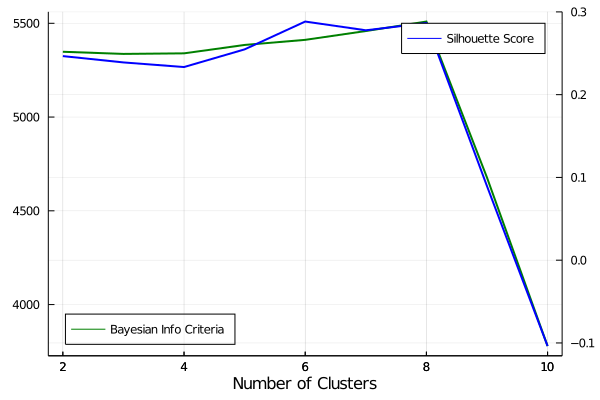

In [731]:
plot(k_range, bics, legend=:bottomleft, label="Bayesian Info Criteria", color=:green, lw=2)
xlabel!("Number of Clusters")
plot!(twinx(),k_range, sil_means, legend=:topright, label="Silhouette Score", color=:blue, lw=2)

In [732]:
savefig("figures/bal_pca_em_metrics_$upper")

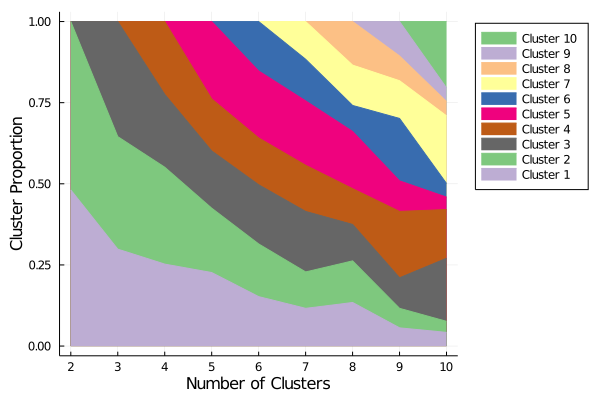

In [733]:
mat = prepare_portfolio(ls)
plotmat = cum_columns(mat, normalize=true)
cum_plot(plotmat)

In [734]:
savefig("figures/bal_pca_em_portfolio_$upper")

In [735]:
collect(zip(assignments[5], y_1h))

499-element Array{Tuple{Int64,Int64},1}:
 (6, 1)
 (3, 1)
 (1, 1)
 (3, 2)
 (5, 1)
 (5, 2)
 (4, 2)
 (4, 2)
 (3, 1)
 (6, 1)
 (2, 2)
 (5, 2)
 (1, 1)
 (6, 1)
 (1, 1)
 (4, 1)
 (1, 2)
 (5, 1)
 (5, 1)
 (4, 2)
 (6, 2)
 (6, 1)
 (6, 1)
 (2, 2)
 (1, 1)
 (4, 2)
 (6, 1)
 (1, 1)
 (2, 2)
 (5, 2)
 (1, 2)
 (5, 3)
 (6, 1)
 (4, 2)
 (6, 1)
 (3, 2)
 (6, 1)
 (1, 1)
 (2, 2)
 (3, 2)
 (1, 3)
 (5, 1)
 (6, 2)
 (6, 1)
 (2, 2)
 (1, 1)
 (4, 2)
 (3, 1)
 ⋮
 (6, 1)
 (3, 2)
 (4, 1)
 (4, 2)
 (5, 3)
 (3, 2)
 (2, 2)
 (5, 3)
 (5, 2)
 (4, 2)
 (5, 2)
 (2, 2)
 (3, 2)
 (6, 1)
 (6, 1)
 (3, 2)
 (2, 2)
 (3, 2)
 (5, 1)
 (3, 1)
 (1, 1)
 (1, 1)
 (6, 1)
 (1, 1)
 (5, 2)
 (5, 2)
 (3, 2)
 (5, 2)
 (2, 2)
 (2, 2)
 (5, 1)
 (5, 1)
 (1, 1)
 (5, 2)
 (5, 2)
 (1, 1)
 (5, 1)
 (5, 1)
 (2, 2)
 (4, 2)
 (6, 1)
 (5, 1)
 (1, 1)
 (2, 2)
 (4, 2)
 (1, 1)
 (1, 1)

In [736]:
mutualinfo(assignments[5], y_1h)

0.18106043328772817

In [737]:
vmeasure(assignments[5], y_1h)

0.181060433287728

In [738]:
randindex(assignments[5], y_1h)

(0.12439620360390352, 0.6030052072015517, 0.3969947927984483, 0.2060104144031034)

In [739]:
varinfo(assignments[5], y_1h)

2.208639616784865

### ICA - Kmeans

In [740]:
ICA_data = convert(Array, ICA_data)

499×3 Array{Float64,2}:
  0.887774   -1.06545     -0.730037
 -1.34191    -0.134882     0.540681
 -0.34165     1.83579     -0.902162
 -1.04246    -1.95555      2.84851
  1.06055     1.04635      0.739048
  0.137714    0.00483524  -2.06977
 -0.574884    1.17903      0.166432
 -0.944609   -0.0515563   -2.83426
 -1.24746    -0.0766545    1.29606
  1.65827    -1.1609      -0.821421
 -1.78447    -1.88294      1.52962
  0.0807314   0.0505134    0.750778
 -1.26357     1.91869      1.25438
  1.96204    -0.0113854    0.0136152
  1.80256     0.97374      2.05794
 -0.98921     1.96663     -1.46567
 -2.05451     1.03931      2.77688
  1.95399     0.986289    -0.00722504
  1.85954     0.928062    -0.762608
 -1.81669     2.10776      1.44626
  1.07666    -0.948997     0.780728
  2.06454    -0.950832     0.789838
  1.94161    -0.986221     1.44473
 -1.76403    -0.908101     0.0985094
  0.617736    1.8568       0.51722
 -0.689765    0.145965     0.842162
  1.87565    -1.06729     -0.720927
 -2.43229   

In [741]:
k_range = 2:upper
total_costs = []
sils = []
ls = []
sil_means = []
assignments = []

for i in k_range
    println("K = $i")
    model = ParallelKMeans.KMeans(k=i, rng=RNG)
    mach = machine(model, ICA_data)
    MLJ.fit!(mach)
    
#     @show report(mach) 
#     @show fitted_params(mach)
    @show mach.report.totalcost # https://github.com/PyDataBlog/ParallelKMeans.jl/blob/87ce07d10796078aacffcbea0b2e9dc0c02f25d7/src/hamerly.jl#L65
    d = countmap(mach.report.assignments)
    
    k = d |> keys
    v = d |> values
    l = sort(collect(zip(k,v)), by=x->x[1])
    @show l
    
    # https://juliastats.org/Clustering.jl/stable/validate.html
    s = silhouettes(mach.report.assignments, dist_mat(ICA_data))
    println("silhouette: $(mean(s))")
    
    push!(assignments, mach.report.assignments)
    push!(ls, l)
    push!(total_costs, mach.report.totalcost) 
    push!(sils, s)
    push!(sil_means, mean(s))
    println("")
end

K = 2
Iteration 1: Jclust = 2993.2541725160813
Iteration 2: Jclust = 2878.792812278331
Iteration 3: Jclust = 2920.5397657653166
Iteration 4: Jclust = 2822.1224001539995
Iteration 5: Jclust = 2718.6085998691756
Iteration 6: Jclust = 2610.2752828646935
Iteration 7: Jclust = 2543.832489057584
Iteration 8: Jclust = 2537.721097985223
Iteration 9: Jclust = 2539.849168221332
Iteration 10: Jclust = 2539.163598240877
Iteration 11: Jclust = 2535.8789791551017
Iteration 12: Jclust = 2540.169580667256
Iteration 13: Jclust = 2516.6635691704905
Iteration 14: Jclust = 2516.6635691704905
Successfully terminated with convergence.
mach.report.totalcost = 2245.7145685188
l = [(1, 253), (2, 246)]
silhouette: 0.2451397349413915

K = 3


┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @458`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @248.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


Iteration 1: Jclust = 2853.765841097382
Iteration 2: Jclust = 2172.9187748168365
Iteration 3: Jclust = 2143.5340034455867
Iteration 4: Jclust = 2045.66683975806
Iteration 5: Jclust = 1973.9449347659977
Iteration 6: Jclust = 1966.9531088455117
Iteration 7: Jclust = 1978.3333435634827
Iteration 8: Jclust = 1966.8101925731683
Iteration 9: Jclust = 1977.9859571158465
Iteration 10: Jclust = 1990.9041926374089
Iteration 11: Jclust = 1990.854003104139
Iteration 12: Jclust = 1979.054394917572
Iteration 13: Jclust = 1979.054394917572
Successfully terminated with convergence.
mach.report.totalcost = 1771.90910717216
l = [(1, 184), (2, 171), (3, 144)]
silhouette: 0.2452041609904419

K = 4
Iteration 1: Jclust = 2555.647473843596
Iteration 2: Jclust = 1739.1720130171816
Iteration 3: Jclust = 1693.9799442786837
Iteration 4: Jclust = 1661.4019403516347
Iteration 5: Jclust = 1622.3531846128276
Iteration 6: Jclust = 1604.1154846706038
Iteration 7: Jclust = 1628.0066610739632
Iteration 8: Jclust = 1631.

┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @005`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @469.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @722`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @665.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @913`:
│ scitype(X) =

silhouette: 0.2517930177232393



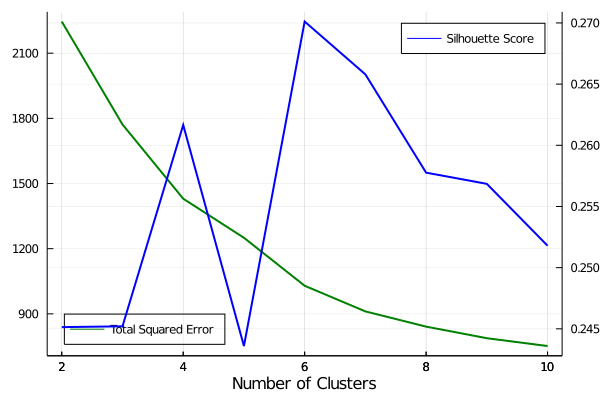

In [742]:
plot(k_range, total_costs, legend=:bottomleft, label="Total Squared Error", color=:green, lw=2)
xlabel!("Number of Clusters")
plot!(twinx(), k_range, sil_means, legend=:topright, label="Silhouette Score", color=:blue, lw=2)

In [743]:
savefig("figures/bal_ica_kmeans_metrics_$upper")

In [744]:
mat = prepare_portfolio(ls)
plotmat = cum_columns(mat, normalize=true)

10×9 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.507014  0.368737  0.274549  0.244489  …  0.108216  0.0881764  0.0821643
 1.0       0.711423  0.49499   0.448898     0.220441  0.194389   0.204409
 1.0       1.0       0.737475  0.625251     0.336673  0.306613   0.260521
 1.0       1.0       1.0       0.835671     0.446894  0.400802   0.344689
 1.0       1.0       1.0       1.0          0.591182  0.53507    0.478958
 1.0       1.0       1.0       1.0       …  0.701403  0.631263   0.55511
 1.0       1.0       1.0       1.0          0.823647  0.737475   0.651303
 1.0       1.0       1.0       1.0          1.0       0.897796   0.811623
 1.0       1.0       1.0       1.0          1.0       1.0        0.907816
 1.0       1.0       1.0       1.0          1.0       1.0        1.0

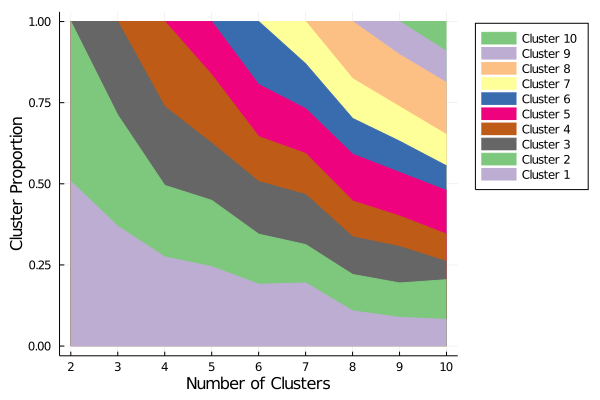

In [745]:
cum_plot(plotmat)

In [746]:
savefig("figures/bal_ica_kmeans_portfolio_$upper")

In [747]:
collect(zip(assignments[5], y_1h))

499-element Array{Tuple{Int64,Int64},1}:
 (6, 1)
 (5, 1)
 (2, 1)
 (4, 2)
 (1, 1)
 (2, 2)
 (5, 2)
 (2, 2)
 (5, 1)
 (6, 1)
 (4, 2)
 (4, 2)
 (5, 1)
 (1, 1)
 (1, 1)
 (2, 1)
 (5, 2)
 (1, 1)
 (1, 1)
 (5, 2)
 (6, 2)
 (6, 1)
 (6, 1)
 (3, 2)
 (1, 1)
 (5, 2)
 (6, 1)
 (5, 1)
 (3, 2)
 (1, 2)
 (5, 2)
 (1, 3)
 (6, 1)
 (3, 2)
 (6, 1)
 (3, 2)
 (6, 1)
 (5, 1)
 (3, 2)
 (4, 2)
 (5, 3)
 (6, 1)
 (4, 2)
 (6, 1)
 (3, 2)
 (1, 1)
 (5, 2)
 (4, 1)
 ⋮
 (6, 1)
 (4, 2)
 (2, 1)
 (2, 2)
 (1, 3)
 (5, 2)
 (4, 2)
 (6, 3)
 (1, 2)
 (2, 2)
 (4, 2)
 (4, 2)
 (3, 2)
 (6, 1)
 (6, 1)
 (3, 2)
 (3, 2)
 (3, 2)
 (1, 1)
 (3, 1)
 (1, 1)
 (1, 1)
 (6, 1)
 (5, 1)
 (1, 2)
 (1, 2)
 (4, 2)
 (6, 2)
 (3, 2)
 (3, 2)
 (1, 1)
 (1, 1)
 (2, 1)
 (1, 2)
 (1, 2)
 (2, 1)
 (2, 1)
 (1, 1)
 (4, 2)
 (5, 2)
 (6, 1)
 (1, 1)
 (1, 1)
 (6, 2)
 (2, 2)
 (5, 1)
 (1, 1)

In [748]:
mutualinfo(assignments[5], y_1h)

0.06041521652150161

In [749]:
vmeasure(assignments[5], y_1h)

0.060415216521501613

In [750]:
randindex(assignments[5], y_1h)

(0.04661448978856605, 0.5677942229841209, 0.43220577701587914, 0.1355884459682417)

In [751]:
varinfo(assignments[5], y_1h)

2.5349608613950956

### ICA - EM 

In [752]:
k_range = 2:upper
bics = []
sils = []
ls = []
sil_means = []
assignments = []

for i in k_range
    println("Gaussians = $i")
    clf = sklearn_m.GaussianMixture(n_components=i, covariance_type="full", random_state=RNG)
    labels = clf.fit_predict(ICA_data) .+ 1; # indexing issues from python to julia functions
    
    d = countmap(labels)
    k = d |> keys
    v = d |> values
    l = sort(collect(zip(k,v)), by=x->x[1])
    @show l
    
    s = silhouettes(labels, dist_mat(ICA_data))
    println("silhouette: $(mean(s))")
    
    bayes_ic = clf.bic(ICA_data)
    @show bayes_ic
    
    push!(ls, l)
    push!(sils, s)
    push!(sil_means, mean(s))
    push!(bics, bayes_ic)
    push!(assignments, labels)
    println("")
end

Gaussians = 2
l = [(1, 263), (2, 236)]
silhouette: 0.2082845186250913
bayes_ic = 5401.291333601637

Gaussians = 3
l = [(1, 153), (2, 165), (3, 181)]
silhouette: 0.22218362890774848
bayes_ic = 5368.069373802576

Gaussians = 4
l = [(1, 87), (2, 108), (3, 161), (4, 143)]
silhouette: 0.2344748297717362
bayes_ic = 5372.203736589486

Gaussians = 5
l = [(1, 67), (2, 99), (3, 139), (4, 97), (5, 97)]
silhouette: 0.24917541488712389
bayes_ic = 5412.796498546593

Gaussians = 6
l = [(1, 47), (2, 84), (3, 104), (4, 73), (5, 81), (6, 110)]
silhouette: 0.2277573679754338
bayes_ic = 5464.329312021113

Gaussians = 7
l = [(1, 68), (2, 54), (3, 82), (4, 103), (5, 65), (6, 81), (7, 46)]
silhouette: 0.12845796533055945
bayes_ic = 5257.878927566377

Gaussians = 8
l = [(1, 37), (2, 65), (3, 101), (4, 38), (5, 44), (6, 76), (7, 81), (8, 57)]
silhouette: 0.18161107459057033
bayes_ic = 5331.780518229751

Gaussians = 9
l = [(1, 36), (2, 55), (3, 94), (4, 70), (5, 43), (6, 77), (7, 67), (8, 26), (9, 31)]
silhouet

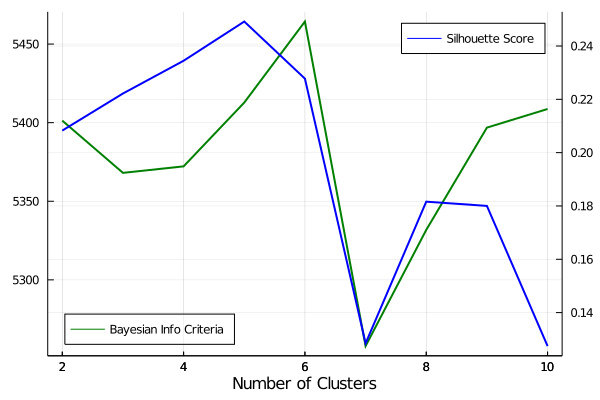

In [753]:
plot(k_range, bics, legend=:bottomleft, label="Bayesian Info Criteria", color=:green, lw=2)
xlabel!("Number of Clusters")
plot!(twinx(),k_range, sil_means, legend=:topright, label="Silhouette Score", color=:blue, lw=2)

In [754]:
savefig("figures/bal_ica_em_metrics_$upper")

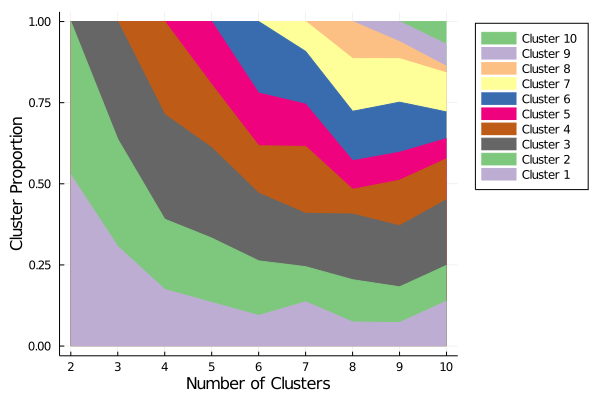

In [755]:
mat = prepare_portfolio(ls)
plotmat = cum_columns(mat, normalize=true)
cum_plot(plotmat)

In [756]:
savefig("figures/bal_ica_em_portfolio_$upper")

In [757]:
collect(zip(assignments[4], y_1h))

499-element Array{Tuple{Int64,Int64},1}:
 (4, 1)
 (2, 1)
 (5, 1)
 (1, 2)
 (3, 1)
 (3, 2)
 (5, 2)
 (2, 2)
 (1, 1)
 (4, 1)
 (1, 2)
 (1, 2)
 (5, 1)
 (3, 1)
 (3, 1)
 (5, 1)
 (5, 2)
 (3, 1)
 (3, 1)
 (5, 2)
 (4, 2)
 (4, 1)
 (4, 1)
 (2, 2)
 (3, 1)
 (1, 2)
 (4, 1)
 (5, 1)
 (2, 2)
 (3, 2)
 (1, 2)
 (3, 3)
 (4, 1)
 (2, 2)
 (4, 1)
 (2, 2)
 (4, 1)
 (5, 1)
 (2, 2)
 (1, 2)
 (5, 3)
 (3, 1)
 (4, 2)
 (4, 1)
 (4, 2)
 (3, 1)
 (5, 2)
 (1, 1)
 ⋮
 (4, 1)
 (1, 2)
 (5, 1)
 (2, 2)
 (3, 3)
 (5, 2)
 (4, 2)
 (2, 3)
 (3, 2)
 (2, 2)
 (1, 2)
 (1, 2)
 (2, 2)
 (4, 1)
 (3, 1)
 (2, 2)
 (2, 2)
 (2, 2)
 (3, 1)
 (4, 1)
 (3, 1)
 (3, 1)
 (3, 1)
 (5, 1)
 (1, 2)
 (3, 2)
 (1, 2)
 (3, 2)
 (2, 2)
 (2, 2)
 (3, 1)
 (3, 1)
 (5, 1)
 (3, 2)
 (3, 2)
 (3, 1)
 (3, 1)
 (3, 1)
 (1, 2)
 (5, 2)
 (4, 1)
 (3, 1)
 (3, 1)
 (4, 2)
 (5, 2)
 (5, 1)
 (3, 1)

In [758]:
mutualinfo(assignments[4], y_1h)

0.06839297910510737

In [759]:
vmeasure(assignments[4], y_1h)

0.06839297910510732

In [760]:
randindex(assignments[4], y_1h)

(0.06438161848208113, 0.5703857514225238, 0.4296142485774762, 0.14077150284504752)

In [761]:
varinfo(assignments[4], y_1h)

2.3257847826373794

### Randomized Projections - Kmeans

In [762]:
k_range = 2:upper
total_costs = []
sils = []
ls = []
sil_means = []
assignments = []

for i in k_range
    println("K = $i")
    model = ParallelKMeans.KMeans(k=i, rng=RNG)
    mach = machine(model, RP_data)
    MLJ.fit!(mach)
    
#     @show report(mach) 
#     @show fitted_params(mach)
    @show mach.report.totalcost # https://github.com/PyDataBlog/ParallelKMeans.jl/blob/87ce07d10796078aacffcbea0b2e9dc0c02f25d7/src/hamerly.jl#L65
    d = countmap(mach.report.assignments)
    
    k = d |> keys
    v = d |> values
    l = sort(collect(zip(k,v)), by=x->x[1])
    @show l
    
    # https://juliastats.org/Clustering.jl/stable/validate.html
    s = silhouettes(mach.report.assignments, dist_mat(RP_data))
    println("silhouette: $(mean(s))")
    
    push!(assignments, mach.report.assignments)
    push!(ls, l)
    push!(total_costs, mach.report.totalcost) 
    push!(sils, s)
    push!(sil_means, mean(s))
    println("")
end

K = 2
Iteration 1: Jclust = 5260.0
Iteration 2: Jclust = 6793.438929241542
Iteration 3: Jclust = 6640.964157413116
Iteration 4: Jclust = 6338.562974104265
Iteration 5: Jclust = 5169.221661423886
Iteration 6: Jclust = 4468.7264946477535
Iteration 7: Jclust = 3914.3718982994224
Iteration 8: Jclust = 3796.44177954756
Iteration 9: Jclust = 3796.44177954756
Successfully terminated with convergence.
mach.report.totalcost = 3205.8834583641874
l = [(1, 261), (2, 238)]


┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @454`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @619.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


silhouette: 0.34632632002894376

K = 3
Iteration 1: Jclust = 3432.000000000001
Iteration 2: Jclust = 3092.0053772716474
Iteration 3: Jclust = 2862.231059548699
Iteration 4: Jclust = 2786.1833304020474
Iteration 5: Jclust = 2687.1808508513714
Iteration 6: Jclust = 2671.400688656711
Iteration 7: Jclust = 2736.3460119713795
Iteration 8: Jclust = 2609.7383459308444
Iteration 9: Jclust = 2609.7383459308444
Successfully terminated with convergence.
mach.report.totalcost = 2325.852774004542
l = [(1, 178), (2, 162), (3, 159)]
silhouette: 0.3347384073983025

K = 4
Iteration 1: Jclust = 3153.333333333334
Iteration 2: Jclust = 2511.0200973665073
Iteration 3: Jclust = 2343.092290362648
Iteration 4: Jclust = 2179.8255505236307
Iteration 5: Jclust = 2072.0327952761563
Iteration 6: Jclust = 2037.729715672069
Iteration 7: Jclust = 2065.8532051069787
Iteration 8: Jclust = 2000.3780072062923
Iteration 9: Jclust = 2041.386913296061
Iteration 10: Jclust = 2006.5969501657778
Iteration 11: Jclust = 2040.418

┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @099`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @607.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @053`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @728.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @341`:
│ scitype(X) =

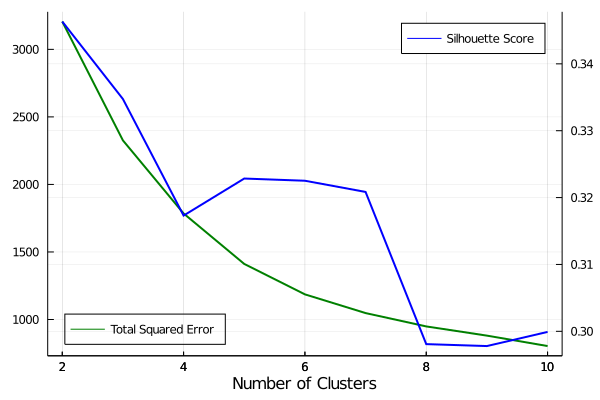

In [763]:
plot(k_range, total_costs, legend=:bottomleft, label="Total Squared Error", color=:green, lw=2)
xlabel!("Number of Clusters")
plot!(twinx(), k_range, sil_means, legend=:topright, label="Silhouette Score", color=:blue, lw=2)

In [764]:
savefig("figures/bal_rp_kmeans_metrics_$upper")

In [765]:
mat = prepare_portfolio(ls)
plotmat = cum_columns(mat, normalize=true)

10×9 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.523046  0.356713  0.254509  0.252505  …  0.146293  0.156313  0.12024
 1.0       0.681363  0.498998  0.43487      0.240481  0.214429  0.170341
 1.0       1.0       0.775551  0.687375     0.408818  0.382766  0.278557
 1.0       1.0       1.0       0.849699     0.509018  0.476954  0.382766
 1.0       1.0       1.0       1.0          0.60521   0.56513   0.470942
 1.0       1.0       1.0       1.0       …  0.733467  0.675351  0.563126
 1.0       1.0       1.0       1.0          0.837675  0.769539  0.649299
 1.0       1.0       1.0       1.0          1.0       0.917836  0.797595
 1.0       1.0       1.0       1.0          1.0       1.0       0.87976
 1.0       1.0       1.0       1.0          1.0       1.0       1.0

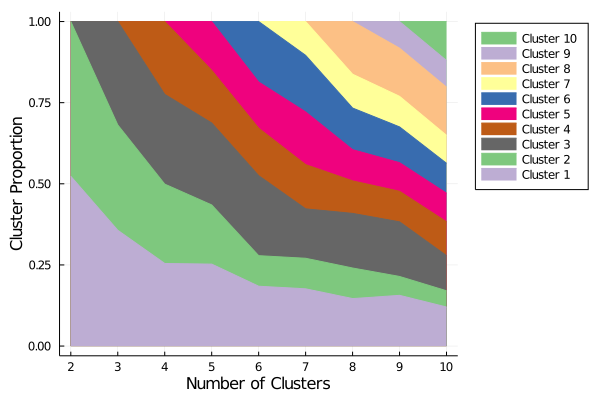

In [766]:
cum_plot(plotmat)

In [767]:
savefig("figures/bal_rp_kmeans_portfolio_$upper")

In [768]:
collect(zip(assignments[4], y_1h))

499-element Array{Tuple{Int64,Int64},1}:
 (1, 1)
 (4, 1)
 (3, 1)
 (2, 2)
 (3, 1)
 (1, 2)
 (3, 2)
 (1, 2)
 (4, 1)
 (1, 1)
 (2, 2)
 (3, 2)
 (4, 1)
 (5, 1)
 (3, 1)
 (3, 1)
 (4, 2)
 (5, 1)
 (5, 1)
 (4, 2)
 (1, 2)
 (1, 1)
 (1, 1)
 (2, 2)
 (3, 1)
 (1, 2)
 (1, 1)
 (4, 1)
 (1, 2)
 (5, 2)
 (4, 2)
 (5, 3)
 (1, 1)
 (2, 2)
 (2, 1)
 (2, 2)
 (1, 1)
 (4, 1)
 (2, 2)
 (2, 2)
 (4, 3)
 (5, 1)
 (1, 2)
 (1, 1)
 (1, 2)
 (3, 1)
 (4, 2)
 (4, 1)
 ⋮
 (1, 1)
 (2, 2)
 (3, 1)
 (1, 2)
 (5, 3)
 (4, 2)
 (1, 2)
 (3, 3)
 (3, 2)
 (1, 2)
 (1, 2)
 (1, 2)
 (2, 2)
 (1, 1)
 (3, 1)
 (2, 2)
 (2, 2)
 (4, 2)
 (5, 1)
 (2, 1)
 (3, 1)
 (3, 1)
 (5, 1)
 (4, 1)
 (3, 2)
 (5, 2)
 (2, 2)
 (1, 2)
 (2, 2)
 (1, 2)
 (5, 1)
 (5, 1)
 (4, 1)
 (3, 2)
 (5, 2)
 (3, 1)
 (3, 1)
 (3, 1)
 (2, 2)
 (3, 2)
 (1, 1)
 (5, 1)
 (3, 1)
 (1, 2)
 (3, 2)
 (3, 1)
 (3, 1)

In [769]:
mutualinfo(assignments[4], y_1h)

0.0753514244455054

In [770]:
vmeasure(assignments[4], y_1h)

0.07535142444550529

In [771]:
randindex(assignments[4], y_1h)

(0.07373004335115343, 0.5747881304778231, 0.4252118695221769, 0.14957626095564625)

In [772]:
varinfo(assignments[4], y_1h)

2.3103099788066945

### Randomized Projections - EM

In [773]:
k_range = 2:upper
bics = []
sils = []
ls = []
sil_means = []
assignments = []

for i in k_range
    println("Gaussians = $i")
    clf = sklearn_m.GaussianMixture(n_components=i, covariance_type="full", random_state=RNG)
    labels = clf.fit_predict(RP_data) .+ 1; # indexing issues from python to julia functions
    
    d = countmap(labels)
    k = d |> keys
    v = d |> values
    l = sort(collect(zip(k,v)), by=x->x[1])
    @show l
    
    s = silhouettes(labels, dist_mat(RP_data))
    println("silhouette: $(mean(s))")
    
    bayes_ic = clf.bic(RP_data)
    @show bayes_ic
    
    push!(ls, l)
    push!(sils, s)
    push!(sil_means, mean(s))
    push!(bics, bayes_ic)
    push!(assignments, labels)
    println("")
end

Gaussians = 2
l = [(1, 212), (2, 287)]
silhouette: 0.26277535152349957
bayes_ic = 5427.201675292648

Gaussians = 3
l = [(1, 59), (2, 172), (3, 268)]
silhouette: 0.2758938341897153
bayes_ic = 5416.76609843632

Gaussians = 4
l = [(1, 61), (2, 147), (3, 218), (4, 73)]
silhouette: 0.28231466206088734
bayes_ic = 5412.070360373979

Gaussians = 5
l = [(1, 66), (2, 112), (3, 180), (4, 69), (5, 72)]
silhouette: 0.24103852527677824
bayes_ic = 5470.166451331186

Gaussians = 6
l = [(1, 47), (2, 114), (3, 99), (4, 57), (5, 82), (6, 100)]
silhouette: 0.24997228029675217
bayes_ic = 5480.543951644163

Gaussians = 7
l = [(1, 57), (2, 77), (3, 102), (4, 41), (5, 103), (6, 90), (7, 29)]
silhouette: 0.06988199379330311
bayes_ic = 2436.53176524451

Gaussians = 8
l = [(1, 22), (2, 99), (3, 25), (4, 101), (5, 51), (6, 4), (7, 94), (8, 103)]
silhouette: 0.011531657457494524
bayes_ic = -775.980029188246

Gaussians = 9
l = [(1, 40), (2, 101), (3, 40), (4, 64), (5, 102), (6, 40), (7, 20), (8, 33), (9, 59)]
silho

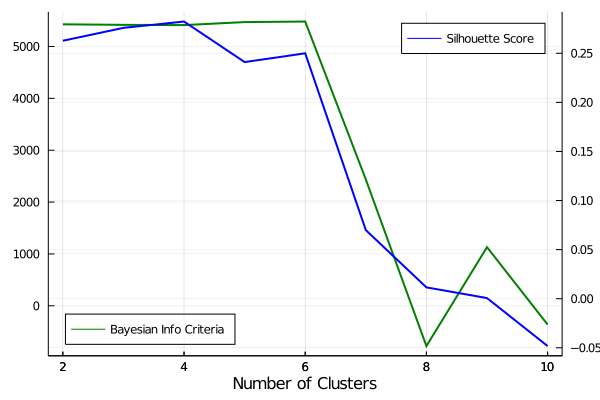

In [774]:
plot(k_range, bics, legend=:bottomleft, label="Bayesian Info Criteria", color=:green, lw=2)
xlabel!("Number of Clusters")
plot!(twinx(),k_range, sil_means, legend=:topright, label="Silhouette Score", color=:blue, lw=2)

In [775]:
savefig("figures/bal_rp_em_metrics_$upper")

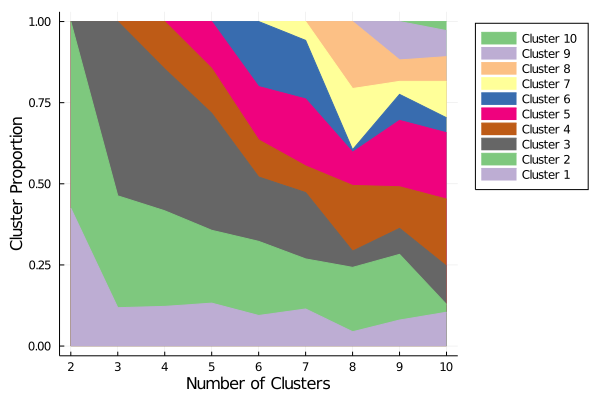

In [776]:
mat = prepare_portfolio(ls)
plotmat = cum_columns(mat, normalize=true)
cum_plot(plotmat)

In [777]:
savefig("figures/bal_rp_em_portfolio_$upper")

In [778]:
collect(zip(assignments[3], y_1h))

499-element Array{Tuple{Int64,Int64},1}:
 (2, 1)
 (1, 1)
 (3, 1)
 (1, 2)
 (3, 1)
 (3, 2)
 (3, 2)
 (3, 2)
 (1, 1)
 (2, 1)
 (2, 2)
 (3, 2)
 (1, 1)
 (4, 1)
 (3, 1)
 (3, 1)
 (1, 2)
 (3, 1)
 (3, 1)
 (3, 2)
 (2, 2)
 (2, 1)
 (2, 1)
 (2, 2)
 (3, 1)
 (3, 2)
 (2, 1)
 (1, 1)
 (2, 2)
 (4, 2)
 (3, 2)
 (3, 3)
 (2, 1)
 (3, 2)
 (2, 1)
 (1, 2)
 (4, 1)
 (1, 1)
 (2, 2)
 (2, 2)
 (1, 3)
 (4, 1)
 (2, 2)
 (2, 1)
 (2, 2)
 (3, 1)
 (3, 2)
 (3, 1)
 ⋮
 (2, 1)
 (1, 2)
 (3, 1)
 (3, 2)
 (4, 3)
 (1, 2)
 (2, 2)
 (3, 3)
 (3, 2)
 (3, 2)
 (2, 2)
 (2, 2)
 (2, 2)
 (2, 1)
 (3, 1)
 (1, 2)
 (2, 2)
 (3, 2)
 (4, 1)
 (2, 1)
 (3, 1)
 (3, 1)
 (4, 1)
 (1, 1)
 (3, 2)
 (4, 2)
 (1, 2)
 (3, 2)
 (2, 2)
 (2, 2)
 (3, 1)
 (3, 1)
 (3, 1)
 (3, 2)
 (4, 2)
 (3, 1)
 (3, 1)
 (3, 1)
 (2, 2)
 (3, 2)
 (2, 1)
 (4, 1)
 (3, 1)
 (4, 2)
 (3, 2)
 (3, 1)
 (3, 1)

In [779]:
mutualinfo(assignments[3], y_1h)

0.031189954672017812

In [780]:
vmeasure(assignments[3], y_1h)

0.031189954672017583

In [781]:
randindex(assignments[3], y_1h)

(0.04356928742574913, 0.5469251756525099, 0.45307482434749013, 0.09385035130501967)

In [782]:
varinfo(assignments[3], y_1h)

2.1053759344304557

### PPCA - Kmeans

In [783]:
PPCA_data = Array(PPCA_data)

499×3 Array{Float64,2}:
 -0.00223926    0.0440831    -0.00130977
  0.0798186    -0.00438858   -0.00878179
  0.0330983    -0.0336627    -0.0454872
  0.0676373     0.0304688     0.0235267
 -0.0280907    -0.00884386   -0.0337198
 -0.0470737    -0.00567415    0.0265228
 -0.0592587    -0.0568754     0.0278539
 -0.0235133    -0.0195702     0.0441198
  0.072212     -0.00800249   -0.0088021
  0.017148      0.0699058    -0.0320864
  0.028122      0.00356109    0.067544
 -0.00681764   -0.00350424    4.15681e-5
  0.0615737    -0.0537016    -0.0411715
 -0.0311189     0.0351295    -0.0350915
  0.0114246     0.0180638    -0.0777371
 -0.0140236    -0.0641843    -0.00149024
  0.0676337    -0.0555898    -0.00745076
 -0.0364381     0.01228      -0.0512762
 -0.0288315     0.0158939    -0.0512559
  0.00684526   -0.0878371     0.00280517
 -0.0174524     0.0368552    -0.00135039
 -0.0334063     0.0543651    -0.0189271
 -0.00567168    0.059064     -0.0321474
  0.00267475   -0.0203734     0.0645999
  0.037272

In [784]:
k_range = 2:upper
total_costs = []
sils = []
ls = []
sil_means = []
assignments = []

for i in k_range
    println("K = $i")
    model = ParallelKMeans.KMeans(k=i, rng=RNG)
    mach = machine(model, PPCA_data)
    MLJ.fit!(mach)
    
#     @show report(mach) 
#     @show fitted_params(mach)
    @show mach.report.totalcost # https://github.com/PyDataBlog/ParallelKMeans.jl/blob/87ce07d10796078aacffcbea0b2e9dc0c02f25d7/src/hamerly.jl#L65
    d = countmap(mach.report.assignments)
    
    k = d |> keys
    v = d |> values
    l = sort(collect(zip(k,v)), by=x->x[1])
    @show l
    
    # https://juliastats.org/Clustering.jl/stable/validate.html
    s = silhouettes(mach.report.assignments, dist_mat(PPCA_data))
    println("silhouette: $(mean(s))")
    
    push!(assignments, mach.report.assignments)
    push!(ls, l)
    push!(total_costs, mach.report.totalcost) 
    push!(sils, s)
    push!(sil_means, mean(s))
    println("")
end

K = 2
Iteration 1: Jclust = 3.052229982515781
Iteration 2: Jclust = 2.2072937130072092
Iteration 3: Jclust = 2.4784553795832793
Iteration 4: Jclust = 2.487338571502075
Iteration 5: Jclust = 2.4690283267732207
Iteration 6: Jclust = 2.4364421270122794
Iteration 7: Jclust = 2.379811850083078
Iteration 8: Jclust = 2.3732451578012177
Iteration 9: Jclust = 2.3645190991428726
Iteration 10: Jclust = 2.3552889630789924
Iteration 11: Jclust = 2.351239615010558
Iteration 12: Jclust = 2.321955166355961
Iteration 13: Jclust = 2.330585958941597
Iteration 14: Jclust = 2.330494677377379
Iteration 15: Jclust = 2.3338051568449916
Iteration 16: Jclust = 2.3338051568449916
Successfully terminated with convergence.
mach.report.totalcost = 2.1127354897386166
l = 

┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @701`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @916.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319


[(1, 248), (2, 251)]
silhouette: 0.23174725256013326

K = 3
Iteration 1: Jclust = 2.332808572418878
Iteration 2: Jclust = 1.738160785988638
Iteration 3: Jclust = 1.88057643439663
Iteration 4: Jclust = 1.8844090769666544
Iteration 5: Jclust = 1.7904365702957687
Iteration 6: Jclust = 1.7680167494481587
Iteration 7: Jclust = 1.7694360784527665
Iteration 8: Jclust = 1.7721816410203148
Iteration 9: Jclust = 1.774504557913013
Iteration 10: Jclust = 1.7563736254002233
Iteration 11: Jclust = 1.7699428135387059
Iteration 12: Jclust = 1.7737562589342057
Iteration 13: Jclust = 1.7708123472486383
Iteration 14: Jclust = 1.7675445568932289
Iteration 15: Jclust = 1.774682529251879
Iteration 16: Jclust = 1.7742853646643701
Iteration 17: Jclust = 1.77636869712335
Iteration 18: Jclust = 1.7810961466958453
Iteration 19: Jclust = 1.7846996272582725
Iteration 20: Jclust = 1.7799173709679945
Iteration 21: Jclust = 1.7799173709679945
Successfully terminated with convergence.
mach.report.totalcost = 1.5730439

┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @169`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @773.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @756`:
│ scitype(X) = AbstractArray{Continuous,2}
│ input_scitype(model) = Table{var"#s45"} where var"#s45"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:116
┌ Info: Training Machine{KMeans} @839.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/Ov46j/src/machines.jl:319
┌ Warning: The scitype of `X`, in `machine(model, X)` is incompatible with `model=KMeans @664`:
│ scitype(X) =

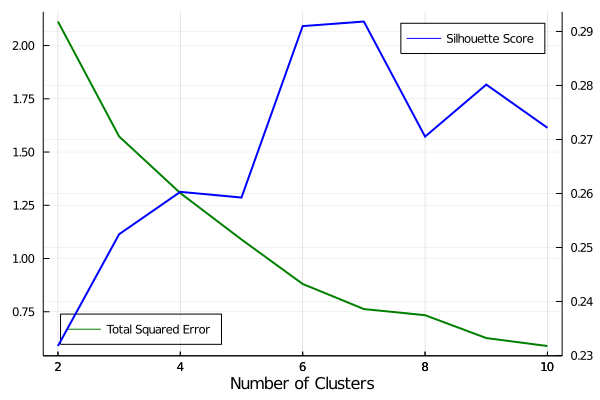

In [785]:
plot(k_range, total_costs, legend=:bottomleft, label="Total Squared Error", color=:green, lw=2)
xlabel!("Number of Clusters")
plot!(twinx(), k_range, sil_means, legend=:topright, label="Silhouette Score", color=:blue, lw=2)

In [786]:
savefig("figures/bal_ppca_kmeans_metrics_$upper")

In [787]:
mat = prepare_portfolio(ls)
plotmat = cum_columns(mat, normalize=true)

10×9 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.496994  0.304609  0.240481  0.182365  …  0.138277  0.108216  0.0901804
 1.0       0.623246  0.470942  0.372745     0.260521  0.244489  0.194389
 1.0       1.0       0.761523  0.59519      0.368737  0.342685  0.286573
 1.0       1.0       1.0       0.783567     0.452906  0.426854  0.368737
 1.0       1.0       1.0       1.0          0.599198  0.559118  0.470942
 1.0       1.0       1.0       1.0       …  0.699399  0.645291  0.559118
 1.0       1.0       1.0       1.0          0.847695  0.775551  0.679359
 1.0       1.0       1.0       1.0          1.0       0.871743  0.795591
 1.0       1.0       1.0       1.0          1.0       1.0       0.917836
 1.0       1.0       1.0       1.0          1.0       1.0       1.0

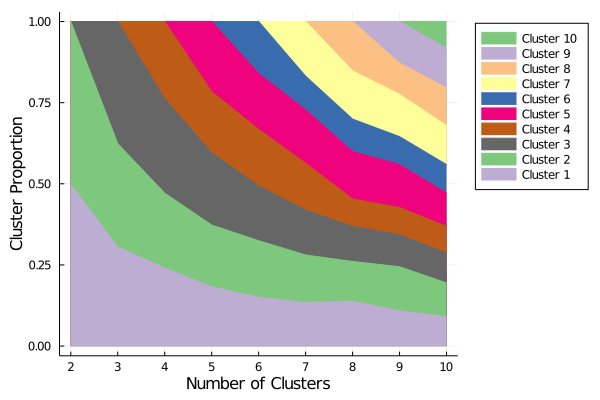

In [788]:
cum_plot(plotmat)

In [789]:
savefig("figures/bal_ppca_kmeans_portfolio_$upper")

In [790]:
collect(zip(assignments[6], y_1h))

499-element Array{Tuple{Int64,Int64},1}:
 (1, 1)
 (3, 1)
 (2, 1)
 (3, 2)
 (7, 1)
 (4, 2)
 (5, 2)
 (4, 2)
 (6, 1)
 (1, 1)
 (4, 2)
 (5, 2)
 (6, 1)
 (1, 1)
 (2, 1)
 (5, 1)
 (6, 2)
 (7, 1)
 (2, 1)
 (5, 2)
 (1, 2)
 (1, 1)
 (1, 1)
 (4, 2)
 (2, 1)
 (5, 2)
 (1, 1)
 (6, 1)
 (4, 2)
 (7, 2)
 (2, 2)
 (7, 3)
 (1, 1)
 (5, 2)
 (1, 1)
 (3, 2)
 (1, 1)
 (6, 1)
 (4, 2)
 (3, 2)
 (6, 3)
 (7, 1)
 (1, 2)
 (1, 1)
 (4, 2)
 (2, 1)
 (5, 2)
 (3, 1)
 ⋮
 (1, 1)
 (3, 2)
 (5, 1)
 (5, 2)
 (7, 3)
 (6, 2)
 (4, 2)
 (2, 3)
 (5, 2)
 (4, 2)
 (4, 2)
 (4, 2)
 (3, 2)
 (1, 1)
 (1, 1)
 (3, 2)
 (4, 2)
 (5, 2)
 (7, 1)
 (3, 1)
 (2, 1)
 (2, 1)
 (7, 1)
 (6, 1)
 (7, 2)
 (7, 2)
 (3, 2)
 (7, 2)
 (4, 2)
 (4, 2)
 (7, 1)
 (7, 1)
 (6, 1)
 (7, 2)
 (7, 2)
 (2, 1)
 (2, 1)
 (5, 1)
 (4, 2)
 (5, 2)
 (1, 1)
 (7, 1)
 (2, 1)
 (7, 2)
 (5, 2)
 (2, 1)
 (2, 1)

In [791]:
mutualinfo(assignments[6], y_1h)

0.16295224072640146

In [792]:
vmeasure(assignments[6], y_1h)

0.16295224072640144

In [793]:
randindex(assignments[6], y_1h)

(0.10585511738712017, 0.5975968000257543, 0.4024031999742457, 0.19519360005150865)

In [794]:
varinfo(assignments[6], y_1h)

2.3849821989379105

### PPCA - EM

In [795]:
k_range = 2:upper
bics = []
sils = []
ls = []
sil_means = []
assignments = []

for i in k_range
    println("Gaussians = $i")
    clf = sklearn_m.GaussianMixture(n_components=i, covariance_type="full", random_state=RNG)
    labels = clf.fit_predict(PPCA_data) .+ 1; # indexing issues from python to julia functions
    
    d = countmap(labels)
    k = d |> keys
    v = d |> values
    l = sort(collect(zip(k,v)), by=x->x[1])
    @show l
    
    s = silhouettes(labels, dist_mat(PPCA_data))
    println("silhouette: $(mean(s))")
    
    bayes_ic = clf.bic(PPCA_data)
    @show bayes_ic
    
    push!(ls, l)
    push!(sils, s)
    push!(sil_means, mean(s))
    push!(bics, bayes_ic)
    push!(assignments, labels)
    println("")
end

Gaussians = 2
l = [(1, 235), (2, 264)]
silhouette: 0.2691731247768554
bayes_ic = -5160.083025497924

Gaussians = 3
l = [(1, 189), (2, 140), (3, 170)]
silhouette: 0.24142834090980597
bayes_ic = -5155.278412361478

Gaussians = 4
l = [(1, 157), (2, 104), (3, 124), (4, 114)]
silhouette: 0.24618463003354318
bayes_ic = -5129.295845005279

Gaussians = 5
l = [(1, 133), (2, 98), (3, 72), (4, 98), (5, 98)]
silhouette: 0.23864879473922795
bayes_ic = -5116.856152368759

Gaussians = 6
l = [(1, 67), (2, 82), (3, 91), (4, 73), (5, 97), (6, 89)]
silhouette: 0.27329641627411067
bayes_ic = -5095.042928204744

Gaussians = 7
l = [(1, 72), (2, 67), (3, 61), (4, 58), (5, 90), (6, 66), (7, 85)]
silhouette: 0.28332180889989705
bayes_ic = -5038.376681647221

Gaussians = 8
l = [(1, 60), (2, 33), (3, 78), (4, 35), (5, 69), (6, 102), (7, 70), (8, 52)]
silhouette: 0.1817535118308562
bayes_ic = -5297.178991248081

Gaussians = 9
l = [(1, 44), (2, 32), (3, 63), (4, 35), (5, 59), (6, 102), (7, 57), (8, 51), (9, 56)]
s

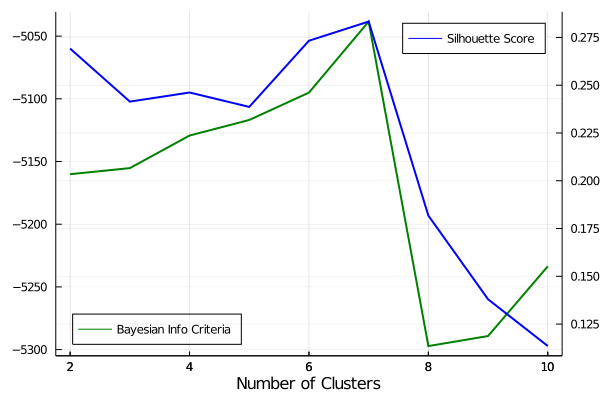

In [796]:
plot(k_range, bics, legend=:bottomleft, label="Bayesian Info Criteria", color=:green, lw=2)
xlabel!("Number of Clusters")
plot!(twinx(),k_range, sil_means, legend=:topright, label="Silhouette Score", color=:blue, lw=2)

In [797]:
savefig("figures/bal_ppca_em_metrics_$upper")

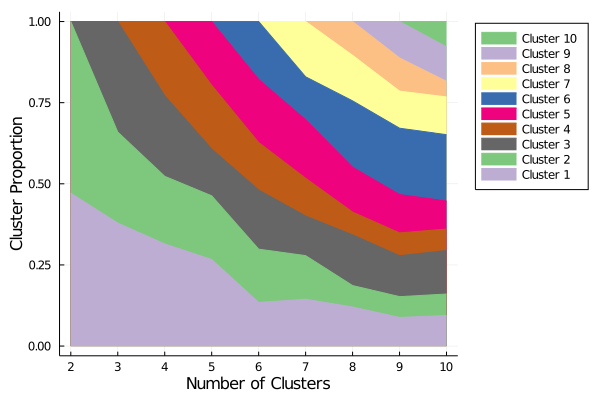

In [798]:
mat = prepare_portfolio(ls)
plotmat = cum_columns(mat, normalize=true)
cum_plot(plotmat)

In [799]:
savefig("figures/bal_ppca_em_portfolio_$upper")

In [800]:
collect(zip(assignments[6], y_1h))

499-element Array{Tuple{Int64,Int64},1}:
 (6, 1)
 (7, 1)
 (1, 1)
 (7, 2)
 (4, 1)
 (2, 2)
 (5, 2)
 (5, 2)
 (7, 1)
 (6, 1)
 (3, 2)
 (5, 2)
 (7, 1)
 (4, 1)
 (1, 1)
 (5, 1)
 (7, 2)
 (4, 1)
 (4, 1)
 (5, 2)
 (2, 2)
 (2, 1)
 (6, 1)
 (3, 2)
 (1, 1)
 (5, 2)
 (6, 1)
 (7, 1)
 (3, 2)
 (4, 2)
 (1, 2)
 (4, 3)
 (6, 1)
 (5, 2)
 (6, 1)
 (7, 2)
 (2, 1)
 (7, 1)
 (3, 2)
 (6, 2)
 (7, 3)
 (2, 1)
 (6, 2)
 (6, 1)
 (3, 2)
 (1, 1)
 (5, 2)
 (6, 1)
 ⋮
 (2, 1)
 (7, 2)
 (5, 1)
 (5, 2)
 (4, 3)
 (7, 2)
 (3, 2)
 (5, 3)
 (5, 2)
 (5, 2)
 (2, 2)
 (3, 2)
 (3, 2)
 (6, 1)
 (6, 1)
 (7, 2)
 (3, 2)
 (5, 2)
 (4, 1)
 (6, 1)
 (1, 1)
 (1, 1)
 (2, 1)
 (7, 1)
 (4, 2)
 (4, 2)
 (7, 2)
 (2, 2)
 (3, 2)
 (3, 2)
 (4, 1)
 (4, 1)
 (1, 1)
 (4, 2)
 (4, 2)
 (1, 1)
 (1, 1)
 (5, 1)
 (3, 2)
 (5, 2)
 (6, 1)
 (4, 1)
 (1, 1)
 (2, 2)
 (5, 2)
 (1, 1)
 (1, 1)

In [801]:
mutualinfo(assignments[6], y_1h)

0.16244095673035566

In [802]:
vmeasure(assignments[6], y_1h)

0.16244095673035547

In [803]:
randindex(assignments[6], y_1h)

(0.09723819127541374, 0.5936209768935461, 0.40637902310645385, 0.18724195378709227)

In [804]:
varinfo(assignments[6], y_1h)

2.3847046385350392